In [286]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
import pandas as pd
import data
from IPython.display import HTML
import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import Model
import ModelTracker
import plot_tools
import writing_tools
import feature_tools
import feature_tracker
import X_tracker

df = data.get_data()
tracker = ModelTracker.ModelTracker()
featureTracker = feature_tracker.FeatureTracker()
data_tracker = X_tracker.X_tracker()

Le but de ce projet est de construire un modèle de prédiction simple afin de me familiariser avec les concepts de base d'intelligence artificielle. 

Le projet va devoir prédire quels clients sont plus susceptibles d'acheter une assurance caravane en fonction des données provenant du CoIL 2000 Challenge. 

Les variables qui commence par M sont des variables qui donne de l'information sur la distribution de la variable dans le zipcode area du client. (0 = aucun, 9 = beaucoup). Ce n'est pas une zone! 

Sa décrit le contexte de vie, pas quelqu'un directement.

Sa ne veut pas dire que la personne soit x, mais qu'elle vit dans une zone où x est fréquent.

ok lol. Plus en plus que j'avance dans le projet, plus en plus je réalise que skip des étapes me ralenti et rend le projet beaucoup plus difficile à suivre. Je me suis créer une liste que je vais suivre à la lettre.

#### 1. **Obtenir et préparer le dataset**
Déja fais

#### 2. **Feature engineering** 
1. **Feature Creation** \
Consiste à créer des nouvelles variables à partir des connaissances métier ou en observant des patterns dans les données.
    - Ex : Créer une nouvelle variable qui nous indique que c'est un high income area
    - Interactions terms
2. **Feature Transformation** \
On ajuste les variables pour améliorer le training du modèle. 
    - One-hot encoding
    - Standardiser
    - transformation mathématique 
3. **Feature Extraction** \
Créer des variables plus synthétiques à partir des existantes pour réduire la dimensionnalité ou capturer l’information essentielle. Ou résumer l'information existante.
    - Réduction de dimension
    - Agrégation et combinaison
4. **Feature Selection** \
Consiste a choisir parmis toutes les variables dispo celles qui sont réellement utiles.
    - Filtrage : supprimer les variables inutiles (très faible corrélation)
    - wrapper ?
5. **Feature Scaling** \
Consiste à garantire que toutes les variables contribuent de manière équilibrée au modèle. 

#### Base Model

In [288]:
X = df.copy()
y = X.pop('CARAVAN')

X_train_base, X_val_base, y_train_base, y_val_base = data.get_split_train_eval_data(df)

X_train_base_np = X_train_base.to_numpy()
y_train_base_np = y_train_base.to_numpy()
X_val_base_np = X_val_base.to_numpy()
y_val_base_np = y_val_base.to_numpy()

In [289]:
w,b = logisticRegression.logistic_regression(X_train_base_np, y_train_base_np)
model = Model.Model(w, b, improvement="Base Model")
BASE_MODEL = "baseModel"
tracker.add(model, name=BASE_MODEL)
model.print_stats(X_val_base_np, y_val_base_np)

Iteration 0: Train cost = 0.6931
Iteration 100: Train cost = 0.2160
Iteration 200: Train cost = 0.2110
Iteration 300: Train cost = 0.2085
Iteration 400: Train cost = 0.2071
Iteration 500: Train cost = 0.2061
Iteration 600: Train cost = 0.2054
Iteration 700: Train cost = 0.2049
Iteration 800: Train cost = 0.2044
Iteration 900: Train cost = 0.2041
Model baseModel saved

Base Model
Accuracy:  0.9399141630901288
[[1095    0]
 [  70    0]]
AUC: 0.7934
F1: 0.0000


In [290]:
import re

mostype = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
mostype_val = np.array([48, 66, 59, 0, 15, 4 ,20, 89, 42, 5])

def read_dictionnary():
    with open("insurance_data/dictionary.txt", "r") as f:
        text = f.read()

    var_categorical = {}
    col_descriptions = {}
    lines = text.splitlines()[149:159]
    entries = [] 
    total = 0
    totalp = 0

    i = 0
    for line in lines:
        words = line.split()
        var_name = words[0]

        if int(var_name) in mostype:
            val = mostype_val[i]
            if val < 10 :
                total += val
                p = mostype_val[i] / 348
                totalp += p
                entries.append( (p, line) )
            i += 1

    entries.sort(reverse=True, key=lambda x: x[0])

    for p, line in entries:
        print(line, f"$\\approx {p:.3f}$ \\")
    print(f'**Total = {total} $\\approx {totalp:.3f}$**')

read_dictionnary()


10 Farmers $\approx 0.014$ \
6 Cruising Seniors $\approx 0.011$ \
4 Career Loners $\approx 0.000$ \
**Total = 9 $\approx 0.026$**


| MOSHOOFD (Customer main type)                |      1 |       2 |       3 |   4 |       5 |      6 |       7 |      8 |      9 |     10 |
|:-------------------------|-------:|--------:|--------:|----:|--------:|-------:|--------:|-------:|-------:|-------:|
| CARAVAN = 1              | 48     | 66      | 59      |   0 | 15      | 4      | 20      | 89     | 42     | 5      |
| P(CARAVAN = 1\|MOSHOOFD) |  0.087 |  0.1315 |  0.0666 |   0 |  0.0264 | 0.0195 |  0.0364 |  0.057 |  0.063 | 0.0181 | 

P(CARAVAN = 1\|MOSHOOFD = 2) $\approx 0.1315$

\

|   MOSHOOFD |   CARAVAN = 1 |   P(MOSHOOFD) |   cumul P(MOSHOOFD) |
|-----------:|--------------:|--------------:|--------------------:|
|          8 |            89 |     0.255747  |            0.255747 |
|          2 |            66 |     0.189655  |            0.445402 |
|          3 |            59 |     0.16954   |            0.614943 |
|          1 |            48 |     0.137931  |            0.752874 |
|          9 |            42 |     0.12069   |            0.873563 |
|          7 |            20 |     0.0574713 |            0.931034 |
|          5 |            15 |     0.0431034 |            0.974138 |
|         10 |             5 |     0.0143678 |            0.988506 |
|          6 |             4 |     0.0114943 |            1        |
|          4 |             0 |     0         |            1        |

La majorité des acheteurs d'assurance caravan sont 

CARAVAN = 1 > 40 \
8 Family with grown ups $\approx 0.256$ \
2 Driven Growers $\approx 0.190$ \
3 Average Family $\approx 0.170$ \
1 Successful hedonists $\approx 0.138$ \
9 Conservative families $\approx 0.121$ \
**Total = 304 $\approx 0.8736$**

CARAVAN = 1 >= 10 \
7 Retired and Religeous $\approx 0.057$ \
5 Living well $\approx 0.043$ \
**Total = 35 $\approx 0.101$**

CARAVAN = 1 < 10 \
10 Farmers $\approx 0.014$ \
6 Cruising Seniors $\approx 0.011$ \
4 Career Loners $\approx 0.000$ \
**Total = 9 $\approx 0.026$**


MOSTYPE = customer sub-type

CARAVAN $ = 1 \geq 10$ 
-   | MOSTYPE   | 1  | 3  | 6  | 8  | 9  | 12 | 13 | 33 | 36 | 37 | 38 | 39 |
    | --------- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN  | 13 | 25 | 12 | 51 | 12 | 16 | 13 | 46 | 16 | 10 | 23 | 19 | 

    1 High Income, expensive child $\approx 0.037 $ \
    3 High status seniors $\approx 0.072 $ \
    6 Career and childcare $\approx 0.034 $ \
    8 Middle class families $\approx 0.147 $ \
    9 Modern, complete families $\approx 0.034 $ \
    12 Affluent young families $\approx 0.046 $ \
    13 Young all american family $\approx 0.037 $ \
    33 Lower class large families $\approx 0.132 $ \
    36 Couples with teens 'Married with children' $\approx 0.046 $ \
    37 Mixed small town dwellers $\approx 0.029 $ \
    38 Traditional families $\approx 0.066 $ \
    39 Large religous families $\approx 0.055 $ \
    **Total** = $256 / 348$ \
    **Total** $\approx 0.7356 $

    Familles $\approx 63.56 \% $ (Total) \
    Familles $\approx 86.40 \% $ si CARAVAN $ = 1 \geq 10$ 

$5 \leq$ CARAVAN $ = 1 \lt 10$ 

-   | MOSTYPE     | 2 | 10 | 11 | 24 | 31 | 32 | 34 | 35 | 41 |
    | ----------- | - | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN = 1 | 6 | 9  | 9  | 5  | 6  | 6  | 9  | 8  | 5  |

    2 Very Important Provincials $\approx 0.017 $ \
    10 Stable family $\approx 0.026 $ \
    11 Family starters $\approx 0.026 $ \
    24 Young, low educated  $\approx 0.014 $ \
    31 Low income catholics $\approx 0.017 $ \
    32 Mixed seniors $\approx 0.023 $ \
    34 Large family, employed child $\approx 0.026 $ \
    35 Village families $\approx 0.023 $ \
    41 Mixed rurals $\approx 0.014 $ \
    **Total** = $65 / 348$ \
    **Total** $\approx 0.1868 $


CARAVAN $ = 1 \lt 5$ 
-   | MOSTYPE     | 4 | 5 | 7 | 20 | 22 | 23 | 25 | 26 | 27 | 29 | 30 |
    | ----------- | - | - | - | -- | -- | -- | -- | -- | -- | -- | -- |
    | CARAVAN = 1 | 2 | 2 | 3 | 2  | 4  | 4  | 2  | 1  | 1  | 2  | 4  |

    4 Affluent senior apartments $\approx 0.006 $ \
    5 Mixed seniors $\approx 0.006 $ \
    7 Dinki's (double income no kids) $\approx 0.009 $ \
    20 Etnically diverse $\approx 0.006 $ \
    22 Mixed apartment dwellers $\approx 0.011 $ \
    23 Young and rising $\approx 0.011 $ \
    25 Young seniors in the city $\approx 0.006 $ \
    26 Own home elderly $\approx 0.003 $ \
    27 Seniors in apartments $\approx 0.003 $ \
    29 Porchless seniors: no front yard $\approx 0.006 $ \
    30 Religious elderly singles $\approx 0.011 $ \
    **Total** = $27 / 348$ \
    **Total** $\approx 0.0776 $



In [291]:
corr_discrete = df.corr(method='spearman').loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns=['CARAVAN'])
corr_top = corr_discrete.unstack().sort_values(ascending=False) #2d a 1d (A,B)
corr_combined = corr_discrete.style.background_gradient(cmap='coolwarm', axis=None).format(precision=4)

display(HTML(corr_combined.to_html()))

top_n = 10
print(f"Les {top_n} variables les plus correlated avec la cible sont :")
data.top_index_and_values(top_n ,corr_top)

# display(myWidgets.AllVarComparator(df.columns, df).get_widget())
# display(myWidgets.TripleAllVarComparator(df.columns, df).get_widget())


,PPERSAUT,APERSAUT,APLEZIER,PPLEZIER,PBRAND,MINKGEM,PWAPART,MKOOPKLA,AWAPART,MHKOOP,MOPLHOOG,MAUT1,MINK4575,ABRAND,ABYSTAND,MRELGE,PBYSTAND,MINK7512,MSKA,MBERHOOG,MZPART,MBERMIDD,MOPLMIDD,MGEMOMV,MGODPR,PGEZONG,AGEZONG,MSKB1,PWAOREG,AWAOREG,AFIETS,MFWEKIND,PFIETS,MBERZELF,AZEILPL,PZEILPL,MGODRK,ALEVEN,AINBOED,PINBOED,PLEVEN,PAANHANG,AAANHANG,AMOTSCO,PMOTSCO,MAUT2,MFGEKIND,MSKB2,MINK123M,MGODOV,MGEMLEEF,AWABEDR,PWABEDR,MAANTHUI,MINK3045,PBESAUT,ABESAUT,APERSONG,PPERSONG,AVRAAUT,PVRAAUT,PWERKT,AWERKT,PTRACTOR,ATRACTOR,AWALAND,PWALAND,MRELSA,MGODGE,ABROM,PBROM,MSKC,MBERARBG,MFALLEEN,MZFONDS,MBERBOER,MBERARBO,MOSTYPE,MRELOV,MSKD,MOSHOOFD,MAUT0,MHHUUR,MINKM30,MOPLLAAG
CARAVAN,0.1637,0.1495,0.1064,0.1064,0.1006,0.1002,0.0953,0.0947,0.0900,0.0799,0.0782,0.0734,0.0699,0.0695,0.0682,0.0682,0.0681,0.0632,0.0600,0.0572,0.0554,0.0410,0.0399,0.0355,0.0348,0.0337,0.0335,0.0309,0.0303,0.0303,0.0289,0.0287,0.0287,0.0266,0.0262,0.0262,0.0196,0.0193,0.0191,0.0190,0.0186,0.0146,0.0145,0.0103,0.0099,0.0084,0.0075,0.0073,0.0072,0.0041,0.0039,0.0006,0.0006,-0.0011,-0.0063,-0.0069,-0.0070,-0.0085,-0.0085,-0.0099,-0.0099,-0.0152,-0.0152,-0.0165,-0.0167,-0.0213,-0.0213,-0.0274,-0.0414,-0.0452,-0.0452,-0.0485,-0.0508,-0.0517,-0.0562,-0.0565,-0.0572,-0.0580,-0.0581,-0.0611,-0.0615,-0.0775,-0.0806,-0.0815,-0.0907


Les 10 variables les plus correlated avec la cible sont :
Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


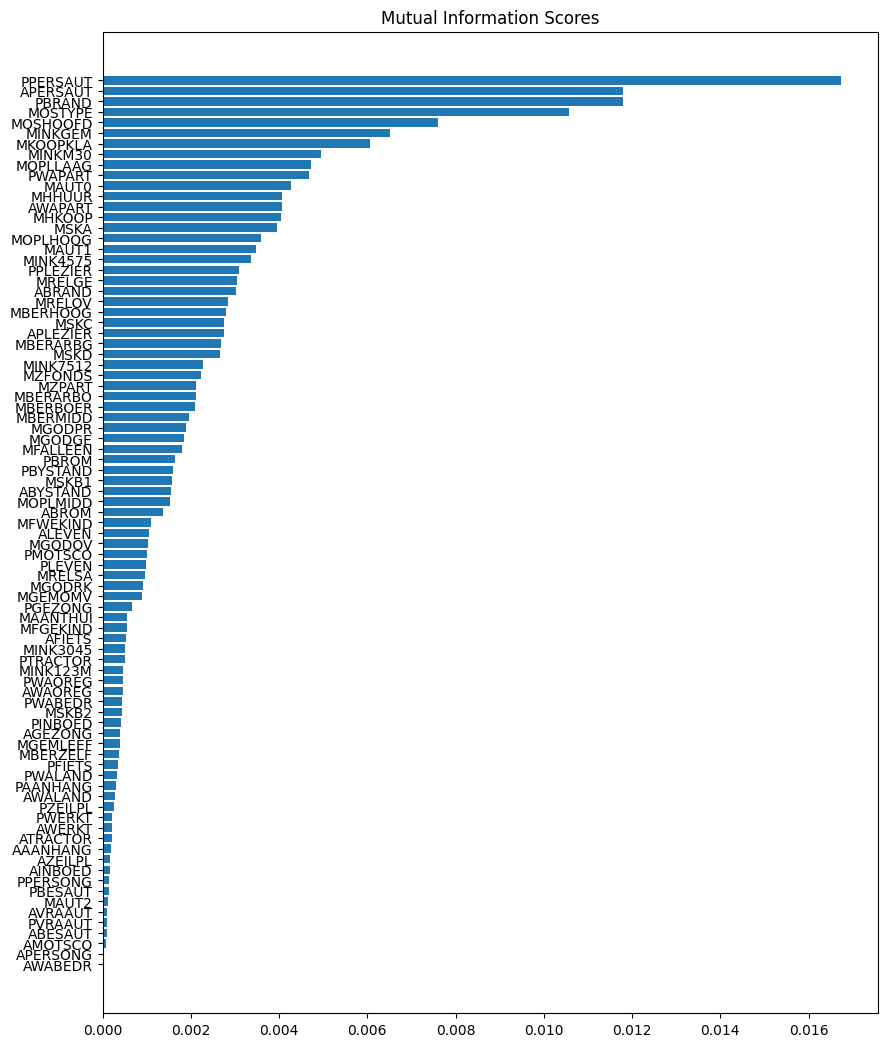

In [292]:
discrete_features = df.dtypes == int
mi = feature_tools.make_mi_scores(X, y, discrete_features)
mi = mi[mi > 0]
feature_tools.plot_mi_scores(mi)

2.2 Feature Transformation

## 2.1 **Feature Creation**
Cette étape est baser sur l'intuition. Le but est de donner des patterns additionnels que le modèle peut ne pas voir.

**L’effet de X sur la probabilité Y change selon la valeur de Z** 

$P(Y | X, Z) = \dfrac{X \cap Z \cap Y}{X \cap Z}$ 

En général, une variation de $p \geq 0.05$ est bonne.

**MHKOOP** x **MAUT1** \
Home owner x 1 car. \
Pour pouvoir utiliser une caravan, il faut au minimum une voiture pour pouvoir la remorquer. De plus, il est plus probable que des home owners ai de la place pour garder une caravan sur leur terrain et aussi les moyens de se payer une caravan. Donc, un endroit avec une plus haute concentration de maison et voiture pourrait peut-être indiquer qu'un client y habitant est plus probable de posseder une assurance caravan.

| MHKOOP      |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|:------------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
| CARAVAN = 1 |  31 |  16 |  19 |  23 |  25 |  26 |  39 |  38 |  37 |  94 |


On peut voir la majorité des acheteurs d'assurance caravan habite dans des environnements à fortes concentration de 'Home owner' (6 à 9). Plus on s'éloigne de 'Forte concentration de Home owner', plus le niveau d'acheteur de Caravan baisse, mais lorsqu'on atteint la concentration '0', on peut observer une remontée.
- $\star$ La remontée est peut-être du aux personnes qui vivent dans des endroits plus pauvres ou peut-être aime le camping ou quelque chose comme ca et donc la quantité de home-owner doit être négligeable.

| MHKOOP                 |       0 |       1 |       2 |       3 |       4 |     5 |       6 |       7 |       8 |       9 |
|:-----------------------|--------:|--------:|--------:|--------:|--------:|------:|--------:|--------:|--------:|--------:|
| CARAVAN = 1            | 31      | 16      | 19      | 23      | 25      | 26    | 39      | 38      | 37      | 94      |
| P(CARAVAN = 1\|MHKOOP) |  0.0408 |  0.0302 |  0.0446 |  0.0602 |  0.0501 |  0.05 |  0.0646 |  0.0525 |  0.0867 |  0.0991 |

Si on observe l'effet de 'Home Owner' sur 'CARAVAN' si on change la valeur de 'MAUT1', on voit que l'intéraction augmente les chances d'avoir une assurance Caravan si la personne habite dans une zone à forte concentration de 'Home owner' et de '1 car' aussi, ce qui confirme mon hypothèse plus haut. 

De plus, on voit que pour un environnement a taux négligeable de 'Home owner', si la personne est aussi dans une zone a très forte concentration de '1 car', alors l'intéraction ajoute $\approx 8 \%$. Donc, ceci est peut-être une indication que ces personnes habites en nature/camping puisque si cet endroit ne possède presque pas de 'Home owner', mais que les personnes possède quand même une caravan, cela indique qu'il est fort probable qu'il possède une voiture puisque sinon comment ils ont ramener leur caravan içi?

(Tableau filtré selon l'espérence de chaque ligne pour ne pas avoir des extravagents et avec une augmentation de chance minimale de 0.05)

|   MHKOOP/MAUT1 |      5 |      7 |      9 |
|---------------:|-------:|-------:|-------:|
|              5 | 0      | 0.0509 | 0      |
|              6 | 0      | 0.0662 | 0      |
|              7 | 0      | 0      | 0.1031 |
|              8 | 0.0525 | 0      | 0      |
|              9 | 0.1198 | 0      | 0.0504 |

Donc, les termes suivants seront ajouté au modèles, car il apporte un gain de précision $\geq 0.05$ : \
(MAUT1 x MHKOOP) 5x8, 5x9, 7x5, 7x6, 9x7, 9x9


**MGEMOMV** x **MRELGE** \
Avg size household 1 to 6 x Married \
La majorité des personnes qui possèdes une assurance caravan sont situés entre un avg size household de 2-3 et un peu dans 4. \
$P($ avg size $= 3$ | Caravan $ = 1) \approx$ 0.49 \
$P($ avg size $= 2$ | Caravan $ = 1) \approx$ 0.33 \
$P($ avg size $= 4$ | caravan $ = 1) \approx$ 0.14. \
De plus, on peut voir que la concentration des personnes marriés et Avg size household 1 to 6 ($A \cap B$) se situe où il y a un avg size household de 2-3-4. 

|   MGEMOMV/MRELGE |   0 |   1 |   2 |   3 |   4 |   5 |   6 |    7 |   8 |   9 |
|-----------------:|----:|----:|----:|----:|----:|----:|----:|-----:|----:|----:|
|                1 |  35 |  53 |  71 |  23 |  39 |  30 |  10 |   23 |   0 |   0 |
|                2 |  29 |  22 |  85 | 195 | 244 | 580 | 399 |  373 |  27 | 177 |
|                3 |   0 |   0 |   1 |  27 |  28 | 311 | 640 | 1024 | 207 | 407 |
|                4 |   0 |   0 |   0 |   1 |  11 |  18 | 115 |  249 | 126 | 173 |
|                5 |   0 |   0 |   0 |   0 |   2 |   7 |   8 |   13 |   1 |  37 |

Donc des personnes mariés augmente les chances d'avoir une taille de ménage > 1 et donc augmente les chances d'avoir une assurance caravan. En plus, on sait que la majorité des acheteurs sont des familles ($\approx 63.56 \% $) \

| MGEMOMV                   |           3 |           2 |          4 |        1 |         5 |
|:--------------------------|------------:|------------:|-----------:|---------:|----------:|
| CARAVAN = 1               | 171         | 115         | 50         | 8        | 4         |
| P(CARAVAN = 1 \| MGEMOMV) |   0.0646503 |   0.0539653 |  0.0721501 | 0.028169 | 0.0588235 |



Gain d'espérence des intéractions : 
|   MGEMOMV/MRELGE |      9 |
|-----------------:|-------:|
|                4 | 0.0666 |

Finalement, une seule intéractions donne une augmentation qui vaut la peine, mais elle est pour une donnée asser rare \
$P($ caravan $= 1$ | avg size $ = 4) \approx$ 0.0722 \
Je crois que sa vaut la peine de l'ajouter puisque ajouter l'intéraction avec 'Married' augmente la probabilité de $\approx$ +0.0666, ce qui pourrait aider le modèle a prédire cette donnée rare. 
| MGEMOMV/MRELGE | 9   |
|----------------|-----|
| 4 (CARAVAN = 1 $\cup$ CARAVAN = 0)             | 173 |
| 4 (CARAVAN = 1)              | 24 |
P(CARAVAN=1 \\| MGEMOMV=4, MRELGE=9) | 0.139 |


**MFWEKIND x MHKOOP** \
Household with children x Home owners


**Tableau de fréquence de Household with children si caravan = 1**
|   MFWEKIND |   CARAVAN = 1 |   P(MFWEKIND) |   cumul P(MFWEKIND) |   P(CARAVAN = 1 \| MFWEKIND) |
|-----------:|--------------:|--------------:|--------------------:|-----------------------------:|
|          4 |            66 |     0.189655  |            0.189655 |                    0.0580475 |
|          3 |            59 |     0.16954   |            0.359195 |                    0.0606372 |
|          5 |            58 |     0.166667  |            0.525862 |                    0.0524412 |
|          6 |            56 |     0.16092   |            0.686782 |                    0.0716113 |
|          2 |            39 |     0.112069  |            0.798851 |                    0.0614173 |
|          7 |            23 |     0.066092  |            0.864943 |                    0.0655271 |
|          8 |            18 |     0.0517241 |            0.916667 |                    0.0873786 |
|          9 |            14 |     0.0402299 |            0.956897 |                    0.0752688 |
|          1 |            10 |     0.0287356 |            0.985632 |                    0.0342466 |
|          0 |             5 |     0.0143678 |            1        |                    0.0326797 |


La majorité des acheteurs d'assurance caravan se situe dans des endroits avec une concentration modérée de household with children (2 à 6).

On sait que la majorité des personnes qui ont une assurance caravan, habite dans un endroit avec majoritairement un sous-type famille (MOSTYPE (customer sub-type) famille $\approx 63.56 \% $). Donc, un endroit avec des "household with children" (donc probablement des familles) devrait avoir plus de chance d'avoir des acheteurs d'assurance Caravan. On sait aussi que la majorité des acheteurs d'assurance caravan habite dans un endroit avec un niveau de concentration de home owner de 6 à 9 (le plus haut). Donc, les endroits avec des "household with children" + "home owner" devrait augmenter les chances d'avoir un acheteur d'assurance Caravan.

|   MFWEKIND/MHKOOP |      2 |      4 |      8 |      9 |
|------------------:|-------:|-------:|-------:|-------:|
|                 2 | 0      | 0.2356 | 0      | 0.0697 |
|                 4 | 0      | 0      | 0.0559 | 0      |
|                 5 | 0      | 0      | 0      | 0.0593 |
|                 6 | 0.0641 | 0      | 0      | 0      |

Les gains additionnels sont situé dans les endroits avec un household with children de concentration 2-4-5-6 ce qui peut être pas mal utile pour le modèle puisque la grande majorité des acheteurs sont situé dans des endroits avec ce taux de concentration de household with children. Sa va permettre d'augmenter la précision globale. 

**Tableau de frequence de MHKOOP si CARAVAN=1**
|   MHKOOP |   CARAVAN = 1 |   P(MHKOOP) |   cumul P(MHKOOP) |
|---------:|--------------:|------------:|------------------:|
|        9 |            94 |   0.270115  |          0.270115 |
|        6 |            39 |   0.112069  |          0.382184 |
|        7 |            38 |   0.109195  |          0.491379 |
|        8 |            37 |   0.106322  |          0.597701 |
|        0 |            31 |   0.0890805 |          0.686782 |
|        5 |            26 |   0.0747126 |          0.761494 |
|        4 |            25 |   0.0718391 |          0.833333 |
|        3 |            23 |   0.066092  |          0.899425 |
|        2 |            19 |   0.0545977 |          0.954023 |
|        1 |            16 |   0.045977  |          1        |

De plus, deux des termes sont situé dans des endroits a bas niveau (2 et 4) de MHKOOP (home owners) ce qui va etre très utile pour le modèle, car la majorité des acheteurs ne sont pas situé dans des endroits avec bas taux de concentration de MHKOOP, donc c'est des informations additionnelles qui vont aider le modèle à prédire des cas rare. Il y a un énorme gain de précision avec le terme de 2x4 (MFWEKIND x MHKOOP) $\approx$ +0.2356!

Les termes qui seront ajoutés sont (MFWEKIND x MHKOOP) : \
2x4, 2x9, 4x8, 5x9, 6x2



**MOSTYPE x MBER\*** \
customer sub-type x statut professionel

Relier le type de client à la concentration d'un certain statut professionnel dans l'endroit où il habite peut nous donner des informations additionnels puisqu'on sait que le type de client influence les chances d'êtres un acheteur d'assurance caravan (la majorité sont des familles). Par exemple si quelqu'un qui est une famille + habite dans un endroit avec une bonne concentration de bon statut professionel, alors il a probablement plus de chance d'avoir les moyens d'avoir une caravan + l'envie de prendre des vacances en caravan avec sa famille, etc

MBERHOOG = High Status
| MOSTYPE/MBERHOOG          |      0 |      1 |      2 |      3 |      4 |      6 |
|:--------------------------|-------:|-------:|-------:|-------:|-------:|-------:|
| High status seniors       | 0      | 0      | 0      | 0      | 0      | 0.0558 |
| Middle class families     | 0.1912 | 0      | 0.0619 | 0.0883 | 0.0947 | 0      |
| Affluent young families   | 0.2462 | 0      | 0.1428 | 0      | 0      | 0      |
| Mixed small town dwellers | 0      | 0.0729 | 0      | 0      | 0      | 0      |

(MOSTYPExMBERHOOG) 3x6, 8x0, 8x2, 8x3, 8x4, 12x0, 12x2, 37x1

**MBERZELF = Entrepreneur**
| MOSTYPE/MBERZELF        |      0 |      1 |
|:------------------------|-------:|-------:|
| High status seniors     | 0      | 0.053  |
| Middle class families   | 0.1141 | 0.0685 |
| Affluent young families | 0.1162 | 0      |

significant interactions: (MOSTYPExMBERZELF) 3x1, 8x0, 8x1, 12x0

**MBERBOER = Farmer**
| MOSTYPE/MBERBOER        |      0 |     1 |
|:------------------------|-------:|------:|
| High status seniors     | 0      | 0.062 |
| Middle class families   | 0.0976 | 0     |
| Affluent young families | 0.0762 | 0     |

significant interactions: (MOSTYPExMBERBOER) 3x1, 8x0, 12x0

**MBERMIDD = Middle management**
| MOSTYPE/MBERMIDD                           |      2 |      3 |      4 |      5 |      7 |      9 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0.1224 | 0      | 0      | 0      | 0      | 0      |
| High status seniors                        | 0      | 0.1091 | 0      | 0      | 0      | 0      |
| Career and childcare                       | 0.1652 | 0      | 0      | 0      | 0      | 0      |
| Middle class families                      | 0      | 0      | 0.1295 | 0.1009 | 0.1705 | 0.1857 |
| Affluent young families                    | 0      | 0      | 0      | 0      | 0.2764 | 0      |
| Couples with teens 'Married with children' | 0.0781 | 0      | 0      | 0      | 0      | 0      |

significant interactions: (MOSTYPExMBERMIDD) 1x2, 3x3, 6x2, 8x4, 8x5, 8x7, 8x9, 12x7, 36x2

**MBERARBG = Skilled workers**
| MOSTYPE/MBERARBG                           |      0 |      1 |      2 |      3 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0      | 0.0678 | 0      | 0      |
| High status seniors                        | 0      | 0      | 0.0578 | 0      |
| Career and childcare                       | 0.0769 | 0      | 0      | 0      |
| Middle class families                      | 0.1196 | 0.0906 | 0      | 0.2189 |
| Modern, complete families                  | 0      | 0.0506 | 0      | 0      |
| Affluent young families                    | 0.134  | 0.0599 | 0      | 0      |
| Couples with teens 'Married with children' | 0      | 0.0851 | 0      | 0      |
| Large religous families                    | 0      | 0      | 0.0691 | 0      |

significant interactions: (MOSTYPExMBERARBG) 1x1, 3x2, 6x0, 8x0, 8x1, 8x3, 9x1, 12x0, 12x1, 36x1, 39x2

**MBERARBO = Unskilled workers**
| MOSTYPE/MBERARBO                           |      0 |      1 |      2 |      3 |      4 |
|:-------------------------------------------|-------:|-------:|-------:|-------:|-------:|
| High Income, expensive child               | 0      | 0.0891 | 0      | 0      | 0      |
| High status seniors                        | 0      | 0      | 0.0562 | 0      | 0      |
| Career and childcare                       | 0.0944 | 0      | 0      | 0      | 0      |
| Middle class families                      | 0.1057 | 0.0709 | 0      | 0      | 0      |
| Affluent young families                    | 0.098  | 0      | 0.103  | 0      | 0      |
| Couples with teens 'Married with children' | 0      | 0      | 0      | 0      | 0.0684 |
| Traditional families                       | 0.1086 | 0      | 0      | 0.0584 | 0      |

significant interactions: (MOSTYPExMBERARBO) 1x1, 3x2, 6x0, 8x0, 8x1, 12x0, 12x2, 36x4, 38x0, 38x3


(MAUT1 x MHKOOP) 5x8, 5x9, 7x5, 7x6, 9x7, 9x9

(MGEMOMV x MRELGE) 4x9

(MFWEKIND x MHKOOP) 2x4, 2x9, 4x8, 5x9, 6x2

(MOSTYPExMBERHOOG) 3x6, 8x0, 8x2, 8x3, 8x4, 12x0, 12x2, 37x1

(MOSTYPExMBERZELF) 3x1, 8x0, 8x1, 12x0

(MOSTYPExMBERBOER) 3x1, 8x0, 12x0

(MOSTYPExMBERMIDD) 1x2, 3x3, 6x2, 8x4, 8x5, 8x7, 8x9, 12x7, 36x2

(MOSTYPExMBERARBG) 1x1, 3x2, 6x0, 8x0, 8x1, 8x3, 9x1, 12x0, 12x1, 36x1, 39x2

(MOSTYPExMBERARBO) 1x1, 3x2, 6x0, 8x0, 8x1, 12x0, 12x2, 36x4, 38x0, 38x3


## 2.2 Feature Transformation
On ajuste les variables pour améliorer le training modèle.

Je vais commencer par one-hot encoding les variables catégoriques non-ordinales, donc 
- MOSTYPE Customer Subtype
- MOSHOOFD Customer main type 

In [293]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int)

## 2.3 Feature Extraction 

Maintenant je vais créer des nouvelles variables. 

Tout les variables qui commence par la lettre A, sont des quantité de police détenues par un client.
- total_policies = nombre total de polices
- total_motor_vehicle_policies = nombre total de polices pour vehicules motorisés


In [294]:
X = df_encoded.copy()
FEATURE1_TAG = "FEAT1"

In [295]:
all_policy_columns = [
    'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT',
    'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG',
    'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND'
]

motorized_columns = ['APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM']

recreational_vehicules = ['APLEZIER', 'AFIETS',  'AZEILPL']

featureTracker.add('total_policies', X[all_policy_columns].sum(axis=1), tag=FEATURE1_TAG)
featureTracker.add('total_motorized_policies', X[motorized_columns].sum(axis=1), tag=FEATURE1_TAG)
featureTracker.add('total_recreational_policies', X[recreational_vehicules].sum(axis=1), tag=FEATURE1_TAG)

Dans la variable total_recreational_policies, 0 domine. Les cas 1-2-3 sont très rares. 

In [296]:
featureTracker.flush_to_df(X)
print(X[X['CARAVAN'] == 1]['total_recreational_policies'].value_counts())


total_recreational_policies
0    320
1     21
2      6
3      1
Name: count, dtype: int64


Alors, je crois que c'est mieux de les réunir en une variable binaire "has_recreational_policies" pour éviter d'ajouter du bruit. De plus, je vais retirer 'APLEZIER', 'AFIETS',  'AZEILPL' pour enlever du bruit, car peu de variables possède ces attributs avec au minimum > 0.

In [297]:
featureTracker.add('has_recreational_vehicule_policie', X[recreational_vehicules].gt(0).any(axis=1).astype(int), FEATURE1_TAG)
if 'total_recreational_policies' in X.columns:
    X.pop('total_recreational_policies')
    X.drop(columns=recreational_vehicules, inplace=True)

Toute les variables qui commence par la lettre P sont des classes discrète de contribution, donc pas les montants exacts. Mais je peux quand même créer : 
- total_contribution
- total_motor_vehicule_contribution

In [298]:
all_contribution_columns = ['PWAPART','PWABEDR','PWALAND','PPERSAUT','PBESAUT','PMOTSCO', 'PVRAAUT','PAANHANG','PTRACTOR','PWERKT','PBROM','PLEVEN',
                            'PPERSONG','PGEZONG','PWAOREG','PBRAND','PZEILPL','PPLEZIER','PFIETS','PINBOED','PBYSTAND']

motorized_contrib_col = ['PPERSAUT','PBESAUT','PMOTSCO','PVRAAUT','PAANHANG','PTRACTOR','PWERKT','PBROM']

recreational_contrib_col = ['PPLEZIER', 'PFIETS',  'PZEILPL']

featureTracker.add('total_contribution', X[all_contribution_columns].sum(axis=1), tag=FEATURE1_TAG)
featureTracker.add('total_motorized_contribution', X[motorized_contrib_col].sum(axis=1), tag=FEATURE1_TAG)
featureTracker.add('total_recreational_contribution',X[recreational_contrib_col].sum(axis=1), tag=FEATURE1_TAG)

Pareil pour total_recreational_contribution, le 0 domine et cette variable risque d'introduire du bruit. Donc, il est mieux de retirer la colonne. Aussi, c'est inutile d'ajouter has_recreational_contribution puisque has_recreational_vehicule_policie capture déja la même information.

In [299]:
featureTracker.flush_to_df(X)
print(X[X['CARAVAN'] == 1][['total_recreational_contribution', 'has_recreational_vehicule_policie']].value_counts())

total_recreational_contribution  has_recreational_vehicule_policie
0                                0                                    320
1                                1                                     18
4                                1                                      4
2                                1                                      2
3                                1                                      2
6                                1                                      1
7                                1                                      1
Name: count, dtype: int64


In [300]:
if 'total_recreational_contribution' in X.columns:
    X.drop('total_recreational_contribution', axis=1, inplace=True)
    X.drop(columns=recreational_contrib_col, inplace=True)

Je peux aussi créer des ratios à l'aide de ces nouvelles variables
- ratio_motorized_policies
- ratio_motorized_contribution

In [301]:
featureTracker.add('ratio_motorized_policies',  X['total_motorized_policies'] / X['total_policies'], tag=FEATURE1_TAG)
featureTracker.add('ratio_motorized_contribution',  X['total_motorized_contribution'] / X['total_contribution'], tag=FEATURE1_TAG)

featureTracker.flush_to_df(X)

X['ratio_motorized_policies'] = X['ratio_motorized_policies'].replace(np.inf, 0)
X['ratio_motorized_policies'] = X['ratio_motorized_policies'].replace(np.nan, 0)
X['ratio_motorized_contribution'] = X['ratio_motorized_contribution'].replace(np.inf, 0)
X['ratio_motorized_contribution'] = X['ratio_motorized_contribution'].replace(np.nan, 0)

37 MINKM30 Income < 30.000 \
38 MINK3045 Income 30-45.000 \
39 MINK4575 Income 45-75.000 \
40 MINK7512 Income 75-122.000 \
41 MINK123M Income >123.000 \
42 MINKGEM Average income

MINKGEM ne donne pas tellement d'informations, c'est seulement un range de 0 à 9. On sais pas c'est quoi le average income, juste un "scaled" average income. Donc, je vais drop tout les MINK* pour une nouvelle variable qui donne le average income de l'endroit où se situe le client. 


## attention, qd tu va split train/eval refais sa pour que sa reste indépendant.

In [302]:
income_brackets_midpoints = {
    'MINKM30': 15000,    
    'MINK3045': 37500,   
    'MINK4575': 60000,   
    'MINK7512': 98500,   
    'MINK123M': 150000 #On va dire que c'est sa
}

income_cols = list(income_brackets_midpoints.keys())
weighted_somme = 0
for col in income_cols:
    weighted_somme += X[col] * income_brackets_midpoints[col]
total = X[income_cols].sum(axis=1)

X.drop(columns=income_cols, inplace=True)
X.drop(columns='MINKGEM', inplace=True)

featureTracker.add('avg_area_income',  weighted_somme / total, tag=FEATURE1_TAG)
featureTracker.flush_to_df(X)

## 2.4 Feature Selection
Consister à choisir parmis toutes les variables dispo celles qui sont réellement utiles.

Avant de débuter, je vais ajouter tout les variables manquantes au dataset (les interactions terms)

In [303]:
X_temp = X.copy()

In [304]:
X = X_temp.copy()

In [305]:
(X.columns.to_list())

['MAANTHUI',
 'MGEMOMV',
 'MGEMLEEF',
 'MGODRK',
 'MGODPR',
 'MGODOV',
 'MGODGE',
 'MRELGE',
 'MRELSA',
 'MRELOV',
 'MFALLEEN',
 'MFGEKIND',
 'MFWEKIND',
 'MOPLHOOG',
 'MOPLMIDD',
 'MOPLLAAG',
 'MBERHOOG',
 'MBERZELF',
 'MBERBOER',
 'MBERMIDD',
 'MBERARBG',
 'MBERARBO',
 'MSKA',
 'MSKB1',
 'MSKB2',
 'MSKC',
 'MSKD',
 'MHHUUR',
 'MHKOOP',
 'MAUT1',
 'MAUT2',
 'MAUT0',
 'MZFONDS',
 'MZPART',
 'MKOOPKLA',
 'PWAPART',
 'PWABEDR',
 'PWALAND',
 'PPERSAUT',
 'PBESAUT',
 'PMOTSCO',
 'PVRAAUT',
 'PAANHANG',
 'PTRACTOR',
 'PWERKT',
 'PBROM',
 'PLEVEN',
 'PPERSONG',
 'PGEZONG',
 'PWAOREG',
 'PBRAND',
 'PINBOED',
 'PBYSTAND',
 'AWAPART',
 'AWABEDR',
 'AWALAND',
 'APERSAUT',
 'ABESAUT',
 'AMOTSCO',
 'AVRAAUT',
 'AAANHANG',
 'ATRACTOR',
 'AWERKT',
 'ABROM',
 'ALEVEN',
 'APERSONG',
 'AGEZONG',
 'AWAOREG',
 'ABRAND',
 'AINBOED',
 'ABYSTAND',
 'CARAVAN',
 'MOSTYPE_1',
 'MOSTYPE_2',
 'MOSTYPE_3',
 'MOSTYPE_4',
 'MOSTYPE_5',
 'MOSTYPE_6',
 'MOSTYPE_7',
 'MOSTYPE_8',
 'MOSTYPE_9',
 'MOSTYPE_10',
 'MOSTYPE

In [306]:
interaction_terms = {
    "MAUT1_MHKOOP": {
        "var1": "MAUT1",
        "var2": "MHKOOP",
        "pairs": "5x8,5x9,7x5,7x6,9x7,9x9",
        "isVar1OneHot": False
    },
    "MGEMOMV_MRELGE": {
        "var1": "MGEMOMV",
        "var2": "MRELGE",
        "pairs": "4x9",
        "isVar1OneHot": False
    },
    "MFWEKIND_MHKOOP": {
        "var1": "MFWEKIND",
        "var2": "MHKOOP",
        "pairs": "2x4,2x9,4x8,5x9,6x2",
        "isVar1OneHot": False
    },
    "MOSTYPE_MBERHOOG": {
        "var1": "MOSTYPE",
        "var2": "MBERHOOG",
        "pairs": "3x6,8x0,8x2,8x3,8x4,12x0,12x2,37x1",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERZELF": {
        "var1": "MOSTYPE",
        "var2": "MBERZELF",
        "pairs": "3x1,8x0,8x1,12x0",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERBOER": {
        "var1": "MOSTYPE",
        "var2": "MBERBOER",
        "pairs": "3x1,8x0,12x0",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERMIDD": {
        "var1": "MOSTYPE",
        "var2": "MBERMIDD",
        "pairs": "1x2,3x3,6x2,8x4,8x5,8x7,8x9,12x7,36x2",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERARBG": {
        "var1": "MOSTYPE",
        "var2": "MBERARBG",
        "pairs": "1x1,3x2,6x0,8x0,8x1,8x3,9x1,12x0,12x1,36x1,39x2",
        "isVar1OneHot": True
    },
    "MOSTYPE_MBERARBO": {
        "var1": "MOSTYPE",
        "var2": "MBERARBO",
        "pairs": "1x1,3x2,6x0,8x0,8x1,12x0,12x2,36x4,38x0,38x3",
        "isVar1OneHot": True
    }
}

for key, spec in interaction_terms.items():
    X = feature_tools.create_interaction_terms(X,
                                  spec['var1'],
                                  spec['var2'],
                                  spec['pairs'],
                                  isVar1OneHot=spec['isVar1OneHot'])


In [307]:
print(X.isna().sum().value_counts())

0    187
Name: count, dtype: int64


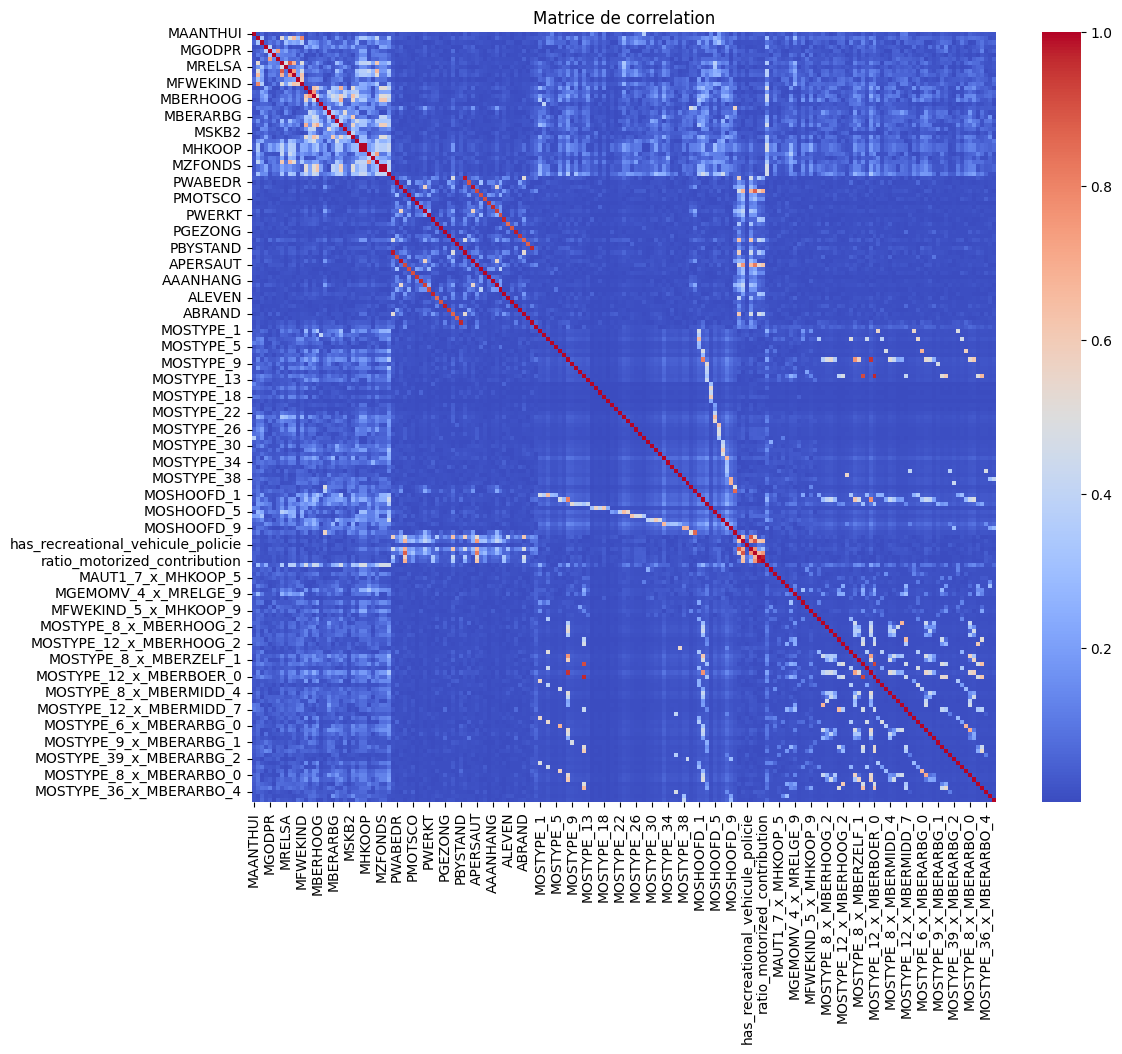

In [308]:
cols_to_drop = feature_tools.find_correlated_cols(X, threshold=0.95)

Les colonnes redondantes sont ceux qui sont presque indentiques (à $\geq$ 0.95). Ils amène pratiquement la meme informations au modèle, donc une des deux paires sera retirés. Je garder celle qui 
1. À des interactions terms
2. Le plus haut niveau de variance

In [309]:
for col1, col2 in cols_to_drop:
    print(col1, " variance : ", X[col1].var())
    print(col2, " variance : ", X[col2].var())
    print()

MHHUUR  variance :  9.543623838560585
MHKOOP  variance :  9.546942076649835

MZFONDS  variance :  3.915317038498481
MZPART  variance :  3.928059738675763

PWAPART  variance :  0.9190138088718947
AWAPART  variance :  0.24269876044254982

PWALAND  variance :  0.250021872459651
AWALAND  variance :  0.020193504853560793

PAANHANG  variance :  0.04526512904160845
AAANHANG  variance :  0.015822082742245606

PBROM  variance :  0.6612913547405973
ABROM  variance :  0.07029584198933711

PGEZONG  variance :  0.03705141533409961
AGEZONG  variance :  0.006486586367288483

PBYSTAND  variance :  0.16732278142121987
ABYSTAND  variance :  0.01440146501203428

ratio_motorized_policies  variance :  0.16569453277980348
ratio_motorized_contribution  variance :  0.16985783907969593

MOSTYPE_8  variance :  0.05485524328019597
MOSTYPE_8_x_MBERBOER_0  variance :  0.050120815084145495

MOSTYPE_12  variance :  0.01870847996146197
MOSTYPE_12_x_MBERBOER_0  variance :  0.017550154642127



In [310]:
print(len(X.columns))

187


In [311]:
cols_to_remove = [
    'MHHUUR', 'MZFONDS', 'AWAPART', 'AWALAND', 'AAANHANG', 
    'ABROM', 'AGEZONG', 'ABYSTAND', 'ratio_motorized_policies', 
    'MOSTYPE_8_x_MBERBOER_0', 'MOSTYPE_12_x_MBERBOER_0'
]

for c in cols_to_remove:
    featureTracker.add_to_removed(X, name=c, tag=FEATURE1_TAG)

In [312]:
X_without_caravan = X.drop(columns=['CARAVAN'])
discrete_features = X_without_caravan.dtypes == int

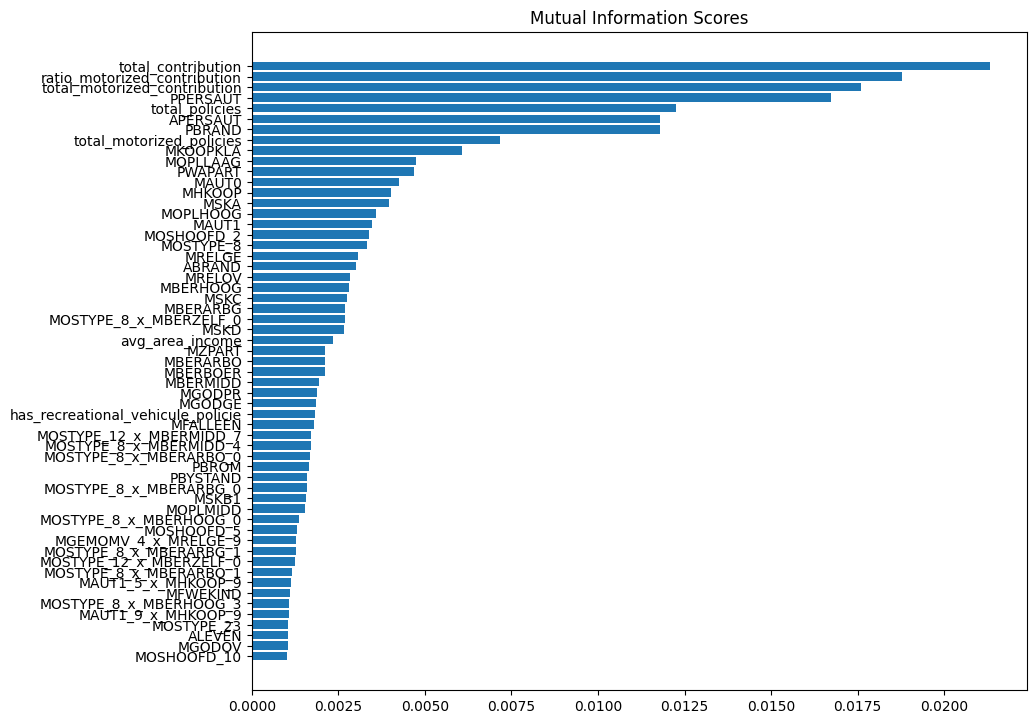

In [313]:
mi = feature_tools.make_mi_scores(X_without_caravan, X['CARAVAN'], discrete_features)
mi = mi[mi > 0.001]
feature_tools.plot_mi_scores(mi)

## 2.5 Feature Scaling

Les variables à standardisés sont les variables continues.

In [314]:
X_train, X_val, y_train, y_val = data.get_split_train_eval_data(X)

DATA_V1 = "Feature_Engineering_v1"
data_tracker.add(DATA_V1, X.copy())

Dataset Feature_Engineering_v1 saved.



In [315]:
float_cols = X.columns[X.dtypes == 'float64']

scaler = StandardScaler()
scaler.fit(X_train[float_cols])
X_train[float_cols] = scaler.transform(X_train[float_cols])
X_val[float_cols] = scaler.transform(X_val[float_cols])


X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()


## Clustering with K-Means
"birds of a feather flock together"

In [316]:
X_cluster = X[float_cols].copy()
kmeans = KMeans(n_clusters=6)
X_cluster['Cluster'] = kmeans.fit_predict(X_cluster)
X_cluster['Cluster'] = X_cluster['Cluster'].astype('category')

X_cluster.head()

,ratio_motorized_contribution,avg_area_income,Cluster
0,0.00,58555.555556,2
1,0.60,27500.000000,1
2,0.75,42500.000000,0
3,0.00,60000.000000,2
4,1.00,33000.000000,3


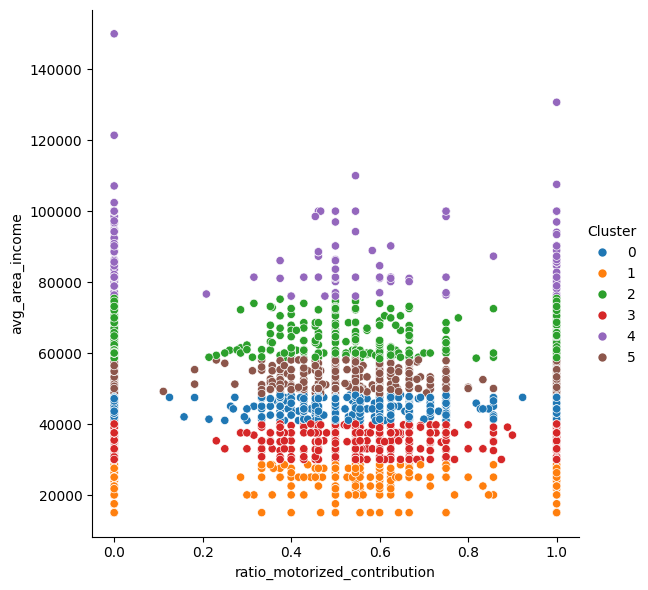

In [317]:
sns.relplot( x="ratio_motorized_contribution", y="avg_area_income", hue="Cluster", data=X_cluster, height=6);

# 3. **Model Optimization & Evaluation**

Maintenant on passe à l'optimization et l'évaluation du modèle. Je vais commencer par préparer le training / validation set. 

La première amélioration que je remarque et que le modèle est BEAUCOUP plus rapide à entrainer.

In [318]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np)
model = Model.Model(w, b, improvement="Added multiple features")
MODEL_WITH_FEATURES_1 = "MF1"
tracker.add(model, name=MODEL_WITH_FEATURES_1)
model.print_stats(X_val_np, y_val_np)

Iteration 0: Train cost = 0.6931
Iteration 100: Train cost = 0.2142
Iteration 200: Train cost = 0.2104
Iteration 300: Train cost = 0.2086
Iteration 400: Train cost = 0.2073
Iteration 500: Train cost = 0.2064
Iteration 600: Train cost = 0.2057
Iteration 700: Train cost = 0.2051
Iteration 800: Train cost = 0.2046
Iteration 900: Train cost = 0.2041
Model MF1 saved

Added multiple features
Accuracy:  0.9399141630901288
[[1095    0]
 [  70    0]]
AUC: 0.7972
F1: 0.0000


Si on compare maintenant, il y a presque aucune différence entre le modèle de base avec le training/validation set de base vs le modèle avec le nouveau set de training/validation.

In [319]:
baseModel = tracker.get_by_name(BASE_MODEL)

In [320]:
t = 0.1
baseModel.print_stats(X_val_base_np, y_val_base_np, threshold=t)
print()
model.print_stats(X_val_np, y_val_np, threshold=t)

Base Model
Accuracy:  0.8180257510729614
[[916 179]
 [ 33  37]]
AUC: 0.7934
F1: 0.2587

Added multiple features
Accuracy:  0.8180257510729614
[[916 179]
 [ 33  37]]
AUC: 0.7972
F1: 0.2587


## **3.1 Handle Class Imbalance**

Maintenant, puisque le data set est imbalanced, je vais ajuster les poids pour que le modèle paye plus attention à la classe positive. La classe positive (CARAVAN = 1) va valoir 1 fois le ratio négative pour positive. La classe négative restera avec un poids de 1.

In [321]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio)
MODEL_WITH_FEAT1_WEIGHT = "MF1_WithClassWeights"
model = Model.Model(w,b,improvement="Added class weight")
tracker.add(model, name=MODEL_WITH_FEAT1_WEIGHT)

w_base, b_base = logisticRegression.logistic_regression(X_train_base_np, y_train_base_np, extra_weight=ratio, to_print=False)
MODEL_BASE_DATASET_WEIGHT = "baseDataSetlWithWeight"
baseModel = Model.Model(w_base, b_base, improvement="Base dataset with weights")

Iteration 0: Train cost = 1.3035
Iteration 100: Train cost = 1.1442
Iteration 200: Train cost = 1.1230
Iteration 300: Train cost = 1.1107
Iteration 400: Train cost = 1.1022
Iteration 500: Train cost = 1.0956
Iteration 600: Train cost = 1.0900
Iteration 700: Train cost = 1.0852
Iteration 800: Train cost = 1.0809
Iteration 900: Train cost = 1.0769
Model MF1_WithClassWeights saved



On peut voir un énorme gain de précision et F1 score avec le training/validation set optimiser. Par contre, le modèle trouve moins d'acheteurs d'assurance Caravan.

In [322]:
baseModel.print_stats(X_val_base_np, y_val_base_np)
print()
model.print_stats(X_val_np, y_val_np)

Base dataset with weights
Accuracy:  0.4068669527896996
[[410 685]
 [  6  64]]
AUC: 0.7519
F1: 0.1563

Added class weight
Accuracy:  0.6824034334763949
[[742 353]
 [ 17  53]]
AUC: 0.7967
F1: 0.2227


# **3.2 Hyperparameter tuning**

Ce sont les paramètres du modèle qui sont configurés avant de training le modèle. 

Je vais commencer par les poids puisqu'ils influencent la taille du gradient quand le modèle fais une erreurs par rapport à la classe CARAVAN = 1. Si je l'optimise plus tard, les résultats des gradients peuvent changer puisque les valeurs du gradient descent seront complètement différentes. Par exemple, pour le learning rate on veut les "steps" optimales pour mettre à jour les paramètres du modèle et on peut la trouvé en analysant la courbe du "loss function". Cette courbe est le résultat du gradient descent, donc si on modifie les poids plus tard, son comportement (l'apprentissage) change et les hyperparamètres optimisés avant ne seront plus valides. 

## **3.2.1 Le poids**

Si on regarde l'effet du poids sur le F1 score et le score de précision, on peut voir que autour du ratio par défaut ($\approx 15.7$). La quantité de recall reste inchangé, mais le score de précision et F1 change un peu. Je vais chercher autour d'un poids de 13 à 15, c'est autour de cette valeur que le nombre de recall reste inchangé, mais que le score F1 et précision change légèrement. 

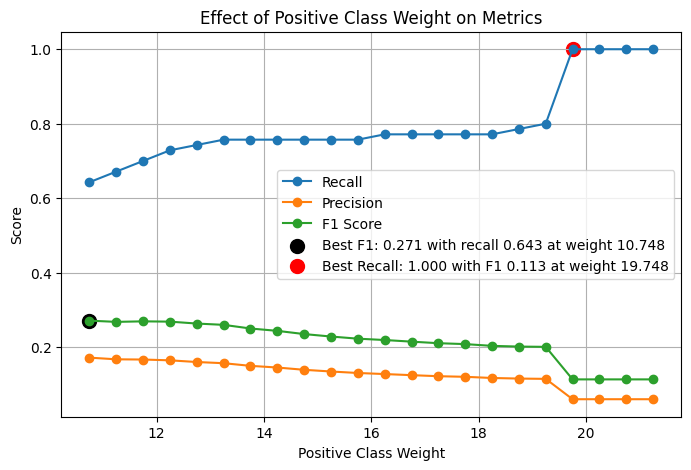

In [323]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

Je vais prendre le poids de 13, puisque le recall semble ne pas augmenter après cette valeur et il offre une bonne balance avec le score précision et F1.

In [324]:
weights_to_test = np.arange(13-1, 16, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

KeyboardInterrupt: 

In [325]:
optimized_ratio = 13
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=optimized_ratio)
model = Model.Model(w, b, improvement="weight class optimization")
MODEL_FEAT1_WEIGHT_OPTI = "ModelFeat1WeightOptimization"
tracker.add(model, name=MODEL_FEAT1_WEIGHT_OPTI)

prevModel = tracker.get_by_name(MODEL_WITH_FEAT1_WEIGHT)
prevModel.print_stats(X_val_np, y_val_np)
print()
model.print_stats(X_val_np, y_val_np)


Iteration 0: Train cost = 1.1898
Iteration 100: Train cost = 1.0386
Iteration 200: Train cost = 1.0197
Iteration 300: Train cost = 1.0089
Iteration 400: Train cost = 1.0014
Iteration 500: Train cost = 0.9955
Iteration 600: Train cost = 0.9907
Iteration 700: Train cost = 0.9865
Iteration 800: Train cost = 0.9827
Iteration 900: Train cost = 0.9792
Model ModelFeat1WeightOptimization saved

Added class weight
Accuracy:  0.6824034334763949
[[742 353]
 [ 17  53]]
AUC: 0.7967
F1: 0.2227

weight class optimization
Accuracy:  0.744206008583691
[[814 281]
 [ 17  53]]
AUC: 0.7965
F1: 0.2624


## 3.2.2 Learning rate

Le learning rate est les "steps" que le modèle prend pour atteindre le minimum du cost function. Un bon learning rate est celui qui converge rapidement et de manière stable (sans osciller) vers le minimum du cost function.

On peut voir que à partir d'un learning rate d'environ 0.015, la loss function commence a être instable.

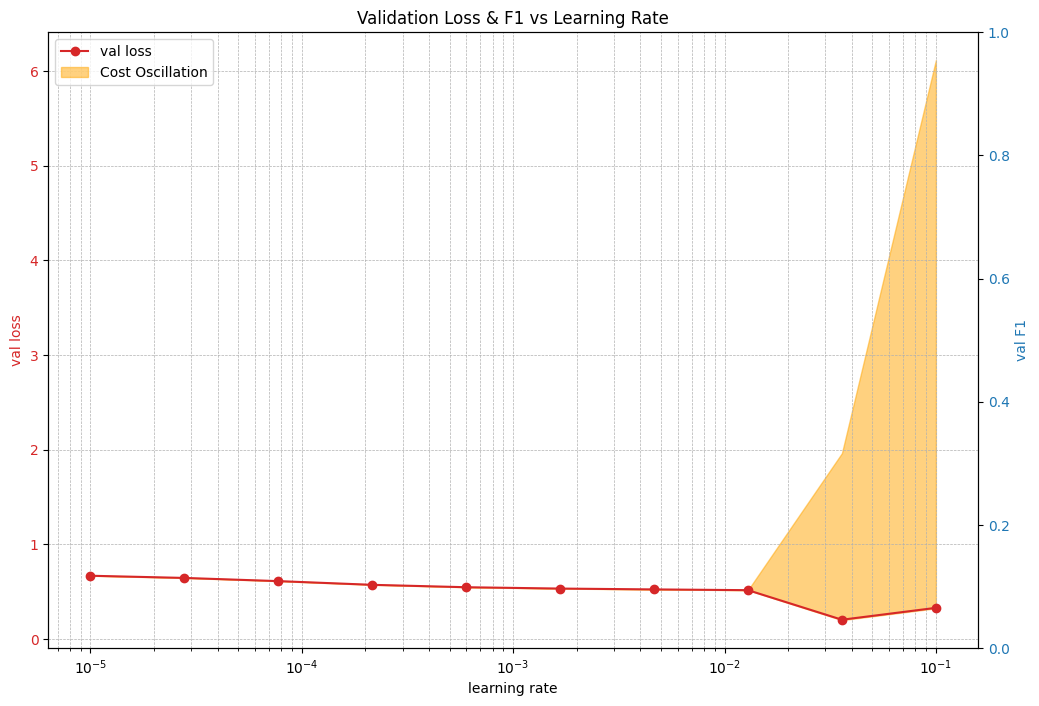

In [ ]:
lrs = np.logspace(start=-5, stop=-1, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, iterations=1000)

Si on cherche avant un learning rate de 0.015, la loss function devient plus stable. On peut voir aussi que celui qui offre le meilleur F1 est situé a un learning rate d'environ 0.000045.

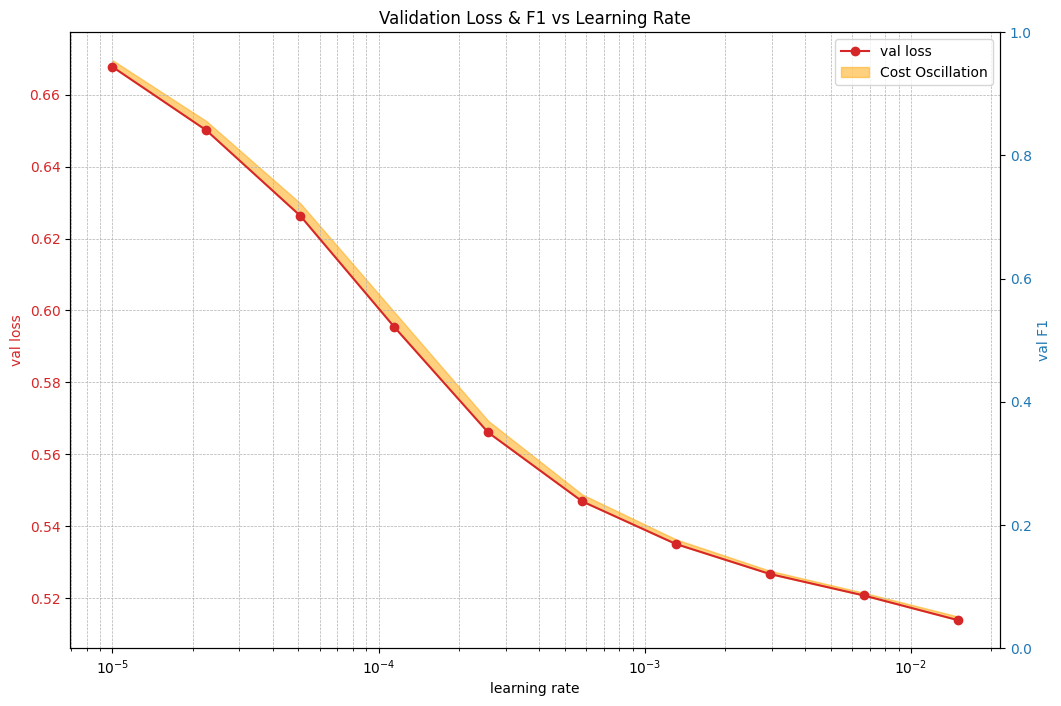

In [ ]:
stop_value = np.log10(0.015)
lrs = np.logspace(start=-5, stop=stop_value, num=10)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, iterations=1000)

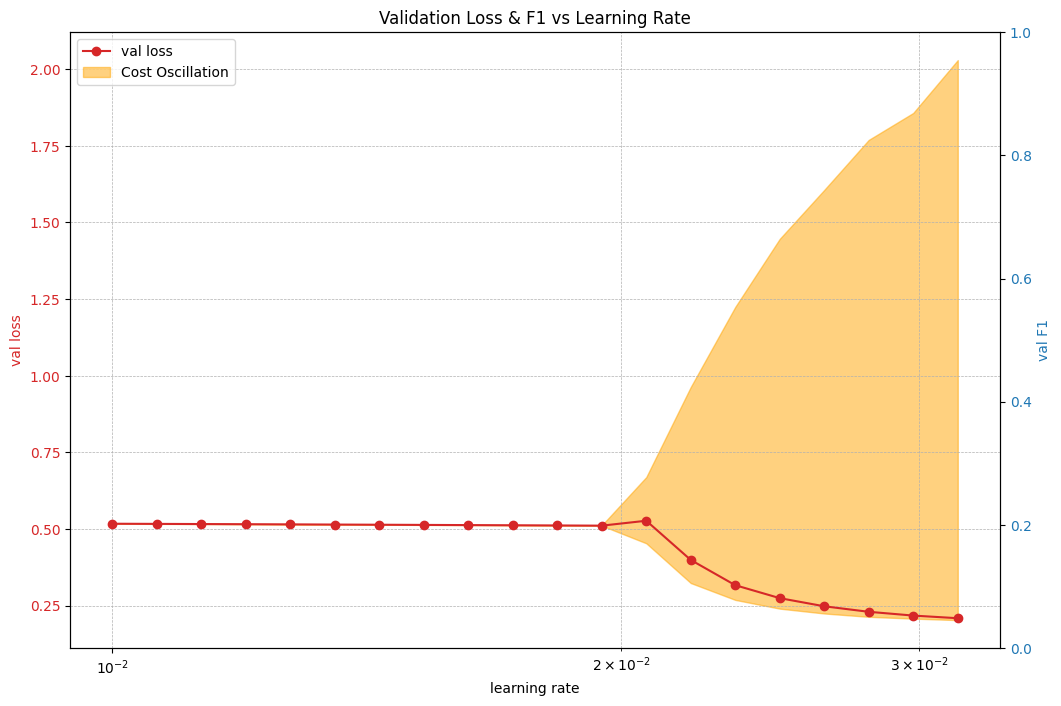

In [ ]:
lrs = np.logspace(start=-2, stop=-1.5, num=20)
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, extra_weight=optimized_ratio, toPlot=True, iterations=1000)

In [326]:
learning_rate_optimized = 0.01

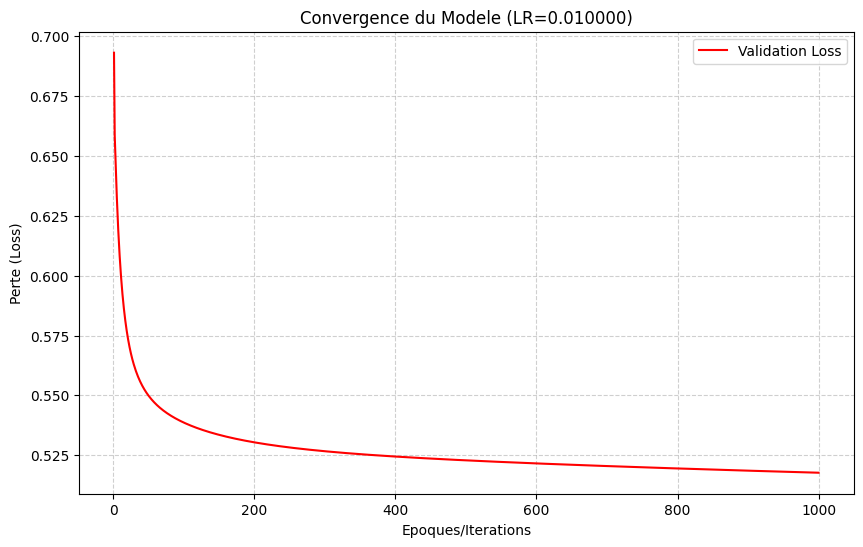

In [327]:
plot_tools.plot_convergence(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=learning_rate_optimized, epochs_max=1000, extra_weight=optimized_ratio, patience=100)

In [328]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, X_val_np, y_val_np, extra_weight=optimized_ratio, learning_rate=learning_rate_optimized, iterations=1000, to_print=False)
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b)
print()
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b )
print(f1_threshold)
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b, f1_threshold)

model = Model.Model(w,b,f1_threshold,improvement="Model V1") 
MODEL_V1 = "modelV1"
tracker.add(model, name=MODEL_V1)

Accuracy:  0.744206008583691
[[814 281]
 [ 17  53]]
AUC: 0.7965
F1: 0.2624

0.67
Accuracy:  0.8918454935622318
[[1012   83]
 [  43   27]]
AUC: 0.7965
F1: 0.3000
Model modelV1 saved



Je crois que le modèle a atteind sa limite, peu importe ce que j'optimise. Le score F1 tourne autour de 0.28-0.3.

In [329]:
y_pred= logisticRegression.predict(X_val_np, w, b, f1_threshold)

tp_indices = np.where((y_val_np == 1) & (y_pred == 1))[0]
fp_indices = np.where((y_val_np == 1) & (y_pred == 0))[0]
tn_indices = np.where((y_val_np == 0) & (y_pred == 0))[0]
fn_indices = np.where((y_val_np == 0) & (y_pred == 1))[0]
X_tp = X_val_np[tp_indices]
X_fp = X_val_np[fp_indices]
X_tn = X_val_np[tn_indices]
X_fn = X_val_np[fn_indices]
X_tp_df = pd.DataFrame(data=X_tp, columns=X_val.columns)
X_fp_df = pd.DataFrame(data=X_fp, columns=X_val.columns)
X_tn_df = pd.DataFrame(data=X_tn, columns=X_val.columns)
X_fn_df = pd.DataFrame(data=X_fn, columns=X_val.columns)

Si on observe les résultats obtenu on peut voir que le modèle priorise majoritairement l'économie du client pour le classer. En moyenne, tout ceux qui ont été classer en tant qu'acheteur d'assurance caravan sont ceux 
- Contribue le plus à leurs polices d'assurances (total_contribution) 
- Habite dans un endroit avec une plus grande concentration de home owner (MHKOOP) et de voiture (MAUT1)
- Ont complété un haut niveau d'étude (MOPLHOOG)
- Moins de bas niveau d'étude (MOPLLAAG) 
- Plus haut niveau de marriage (MRELGE)

Clairement, il classifie selon leur statut économique en premier

Si on observe seulement les TP, on peut voir un certain trait unique:
- Leur niveau d'éducation est majoritairement 'moyen' (MOPLMIDD) et peu de 'bas' (MOPLLAG)

Ensuite, si on regarde les FN et FP, on peut voir que les FN possède un haut niveau d'éducation "haut" (MOPLHOOG), mais les FP contient peu de MOPLHOOG. Si on regarde aussi MOPLLAAG et MOPLMIDD on peut voir qu'il y a une balance entre les deux pour les FP.


 
<style type="text/css">
#T_963df_row0_col1, #T_963df_row1_col2, #T_963df_row2_col1, #T_963df_row3_col2 {
  background-color: rgba(128, 0, 38, 1.0);
  color: black;
}
#T_963df_row0_col2 {
  background-color: rgba(220, 21, 29, 1.0);
  color: black;
}
#T_963df_row0_col3 {
  background-color: rgba(253, 157, 67, 1.0);
  color: black;
}
#T_963df_row0_col4 {
  background-color: rgba(228, 29, 28, 1.0);
  color: black;
}
#T_963df_row0_col5 {
  background-color: rgba(183, 0, 38, 1.0);
  color: black;
}
#T_963df_row0_col6, #T_963df_row1_col6, #T_963df_row2_col6, #T_963df_row3_col6 {
  background-color: rgba(255, 255, 204, 1.0);
  color: black;
}
#T_963df_row1_col1 {
  background-color: rgba(212, 16, 31, 1.0);
  color: black;
}
#T_963df_row1_col3 {
  background-color: rgba(246, 67, 39, 1.0);
  color: black;
}
#T_963df_row1_col4 {
  background-color: rgba(207, 12, 33, 1.0);
  color: black;
}
#T_963df_row1_col5 {
  background-color: rgba(177, 0, 38, 1.0);
  color: black;
}
#T_963df_row2_col2 {
  background-color: rgba(152, 0, 38, 1.0);
  color: black;
}
#T_963df_row2_col3 {
  background-color: rgba(252, 140, 59, 1.0);
  color: black;
}
#T_963df_row2_col4 {
  background-color: rgba(205, 11, 33, 1.0);
  color: black;
}
#T_963df_row2_col5 {
  background-color: rgba(139, 0, 38, 1.0);
  color: black;
}
#T_963df_row3_col1 {
  background-color: rgba(253, 175, 74, 1.0);
  color: black;
}
#T_963df_row3_col3 {
  background-color: rgba(254, 214, 115, 1.0);
  color: black;
}
#T_963df_row3_col4 {
  background-color: rgba(252, 116, 52, 1.0);
  color: black;
}
#T_963df_row3_col5 {
  background-color: rgba(238, 49, 34, 1.0);
  color: black;
}
</style>
<table id="T_963df" style="border-collapse:collapse; width:80%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_963df_level0_col0" class="col_heading level0 col0" >Category</th>
      <th id="T_963df_level0_col1" class="col_heading level0 col1" >MOPLLAAG</th>
      <th id="T_963df_level0_col2" class="col_heading level0 col2" >MOPLMIDD</th>
      <th id="T_963df_level0_col3" class="col_heading level0 col3" >MOPLHOOG</th>
      <th id="T_963df_level0_col4" class="col_heading level0 col4" >Moyenne</th>
      <th id="T_963df_level0_col5" class="col_heading level0 col5" >Moyenne_2</th>
      <th id="T_963df_level0_col6" class="col_heading level0 col6" >Diff_MID_LLAAG</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_963df_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_963df_row0_col0" class="data row0 col0" >TN</td>
      <td id="T_963df_row0_col1" class="data row0 col1" >4.723320</td>
      <td id="T_963df_row0_col2" class="data row0 col2" >3.329051</td>
      <td id="T_963df_row0_col3" class="data row0 col3" >1.328063</td>
      <td id="T_963df_row0_col4" class="data row0 col4" >3.126812</td>
      <td id="T_963df_row0_col5" class="data row0 col5" >4.026186</td>
      <td id="T_963df_row0_col6" class="data row0 col6" >-1.394269</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_963df_row1_col0" class="data row1 col0" >FN</td>
      <td id="T_963df_row1_col1" class="data row1 col1" >3.096386</td>
      <td id="T_963df_row1_col2" class="data row1 col2" >3.734940</td>
      <td id="T_963df_row1_col3" class="data row1 col3" >2.650602</td>
      <td id="T_963df_row1_col4" class="data row1 col4" >3.160643</td>
      <td id="T_963df_row1_col5" class="data row1 col5" >3.415663</td>
      <td id="T_963df_row1_col6" class="data row1 col6" >0.638554</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_963df_row2_col0" class="data row2 col0" >FP</td>
      <td id="T_963df_row2_col1" class="data row2 col1" >3.860465</td>
      <td id="T_963df_row2_col2" class="data row2 col2" >3.651163</td>
      <td id="T_963df_row2_col3" class="data row2 col3" >1.837209</td>
      <td id="T_963df_row2_col4" class="data row2 col4" >3.116279</td>
      <td id="T_963df_row2_col5" class="data row2 col5" >3.755814</td>
      <td id="T_963df_row2_col6" class="data row2 col6" >-0.209302</td>
    </tr>
    <tr>
      <th id="T_963df_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_963df_row3_col0" class="data row3 col0" >TP</td>
      <td id="T_963df_row3_col1" class="data row3 col1" >2.703704</td>
      <td id="T_963df_row3_col2" class="data row3 col2" >4.370370</td>
      <td id="T_963df_row3_col3" class="data row3 col3" >2.370370</td>
      <td id="T_963df_row3_col4" class="data row3 col4" >3.148148</td>
      <td id="T_963df_row3_col5" class="data row3 col5" >3.537037</td>
      <td id="T_963df_row3_col6" class="data row3 col6" >1.666667</td>
    </tr>
  </tbody>
</table>




Donc, les acheteurs d'assurance caravan ont un moyenne d'éducation "moyen"
- $\star$ Les FP ont aussi un niveau d'éducation moyen avec un mélange de bas. Créer une colonne "moyenne d'éducation moyen et bas" pourrait aider le modèle ou différence d'éducation.



<style type="text/css">
#T_8d02d_row0_col1 {
  background-color: rgba(254, 233, 151, 1.0);
  color: black;
}
#T_8d02d_row0_col2 {
  background-color: rgba(254, 232, 150, 1.0);
  color: black;
}
#T_8d02d_row0_col3 {
  background-color: rgba(253, 157, 67, 1.0);
  color: black;
}
#T_8d02d_row0_col4, #T_8d02d_row1_col4, #T_8d02d_row2_col4, #T_8d02d_row3_col4 {
  background-color: rgba(128, 0, 38, 1.0);
  color: black;
}
#T_8d02d_row0_col5, #T_8d02d_row1_col5, #T_8d02d_row2_col5, #T_8d02d_row3_col5 {
  background-color: rgba(255, 255, 204, 1.0);
  color: black;
}
#T_8d02d_row0_col6 {
  background-color: rgba(254, 186, 84, 1.0);
  color: black;
}
#T_8d02d_row0_col7 {
  background-color: rgba(252, 124, 55, 1.0);
  color: black;
}
#T_8d02d_row0_col8, #T_8d02d_row2_col2 {
  background-color: rgba(254, 202, 101, 1.0);
  color: black;
}
#T_8d02d_row1_col1 {
  background-color: rgba(249, 73, 40, 1.0);
  color: black;
}
#T_8d02d_row1_col2 {
  background-color: rgba(252, 134, 58, 1.0);
  color: black;
}
#T_8d02d_row1_col3 {
  background-color: rgba(252, 86, 44, 1.0);
  color: black;
}
#T_8d02d_row1_col6 {
  background-color: rgba(252, 114, 52, 1.0);
  color: black;
}
#T_8d02d_row1_col7 {
  background-color: rgba(235, 42, 32, 1.0);
  color: black;
}
#T_8d02d_row1_col8 {
  background-color: rgba(252, 110, 51, 1.0);
  color: black;
}
#T_8d02d_row2_col1 {
  background-color: rgba(252, 116, 52, 1.0);
  color: black;
}
#T_8d02d_row2_col3 {
  background-color: rgba(245, 63, 38, 1.0);
  color: black;
}
#T_8d02d_row2_col6 {
  background-color: rgba(252, 140, 59, 1.0);
  color: black;
}
#T_8d02d_row2_col7 {
  background-color: rgba(246, 67, 39, 1.0);
  color: black;
}
#T_8d02d_row2_col8 {
  background-color: rgba(253, 147, 62, 1.0);
  color: black;
}
#T_8d02d_row3_col1 {
  background-color: rgba(226, 25, 28, 1.0);
  color: black;
}
#T_8d02d_row3_col2 {
  background-color: rgba(222, 22, 29, 1.0);
  color: black;
}
#T_8d02d_row3_col3 {
  background-color: rgba(204, 10, 33, 1.0);
  color: black;
}
#T_8d02d_row3_col6 {
  background-color: rgba(243, 60, 37, 1.0);
  color: black;
}
#T_8d02d_row3_col7 {
  background-color: rgba(192, 2, 37, 1.0);
  color: black;
}
#T_8d02d_row3_col8 {
  background-color: rgba(212, 16, 31, 1.0);
  color: black;
}
</style>
<table id="T_8d02d" style="border-collapse:collapse; width:90%;">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_8d02d_level0_col0" class="col_heading level0 col0" >Category</th>
      <th id="T_8d02d_level0_col1" class="col_heading level0 col1" >MSKA</th>
      <th id="T_8d02d_level0_col2" class="col_heading level0 col2" >MSKB1</th>
      <th id="T_8d02d_level0_col3" class="col_heading level0 col3" >MSKB2</th>
      <th id="T_8d02d_level0_col4" class="col_heading level0 col4" >MSKC</th>
      <th id="T_8d02d_level0_col5" class="col_heading level0 col5" >MSKD</th>
      <th id="T_8d02d_level0_col6" class="col_heading level0 col6" >Moyenne</th>
      <th id="T_8d02d_level0_col7" class="col_heading level0 col7" >Moyenne_B1B2C</th>
      <th id="T_8d02d_level0_col8" class="col_heading level0 col8" >Moyenne_B1B2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_8d02d_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_8d02d_row0_col0" class="data row0 col0" >TN</td>
      <td id="T_8d02d_row0_col1" class="data row0 col1" >1.522727</td>
      <td id="T_8d02d_row0_col2" class="data row0 col2" >1.537549</td>
      <td id="T_8d02d_row0_col3" class="data row0 col3" >2.304348</td>
      <td id="T_8d02d_row0_col4" class="data row0 col4" >3.787549</td>
      <td id="T_8d02d_row0_col5" class="data row0 col5" >1.121542</td>
      <td id="T_8d02d_row0_col6" class="data row0 col6" >2.054743</td>
      <td id="T_8d02d_row0_col7" class="data row0 col7" >2.543149</td>
      <td id="T_8d02d_row0_col8" class="data row0 col8" >1.920949</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_8d02d_row1_col0" class="data row1 col0" >FN</td>
      <td id="T_8d02d_row1_col1" class="data row1 col1" >2.240964</td>
      <td id="T_8d02d_row1_col2" class="data row1 col2" >1.915663</td>
      <td id="T_8d02d_row1_col3" class="data row1 col3" >2.168675</td>
      <td id="T_8d02d_row1_col4" class="data row1 col4" >3.216867</td>
      <td id="T_8d02d_row1_col5" class="data row1 col5" >0.542169</td>
      <td id="T_8d02d_row1_col6" class="data row1 col6" >2.016867</td>
      <td id="T_8d02d_row1_col7" class="data row1 col7" >2.433735</td>
      <td id="T_8d02d_row1_col8" class="data row1 col8" >2.042169</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_8d02d_row2_col0" class="data row2 col0" >FP</td>
      <td id="T_8d02d_row2_col1" class="data row2 col1" >2.186047</td>
      <td id="T_8d02d_row2_col2" class="data row2 col2" >1.418605</td>
      <td id="T_8d02d_row2_col3" class="data row2 col3" >2.511628</td>
      <td id="T_8d02d_row2_col4" class="data row2 col4" >3.558140</td>
      <td id="T_8d02d_row2_col5" class="data row2 col5" >0.511628</td>
      <td id="T_8d02d_row2_col6" class="data row2 col6" >2.037209</td>
      <td id="T_8d02d_row2_col7" class="data row2 col7" >2.496124</td>
      <td id="T_8d02d_row2_col8" class="data row2 col8" >1.965116</td>
    </tr>
    <tr>
      <th id="T_8d02d_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_8d02d_row3_col0" class="data row3 col0" >TP</td>
      <td id="T_8d02d_row3_col1" class="data row3 col1" >2.222222</td>
      <td id="T_8d02d_row3_col2" class="data row3 col2" >2.259259</td>
      <td id="T_8d02d_row3_col3" class="data row3 col3" >2.407407</td>
      <td id="T_8d02d_row3_col4" class="data row3 col4" >2.851852</td>
      <td id="T_8d02d_row3_col5" class="data row3 col5" >0.333333</td>
      <td id="T_8d02d_row3_col6" class="data row3 col6" >2.014815</td>
      <td id="T_8d02d_row3_col7" class="data row3 col7" >2.506173</td>
      <td id="T_8d02d_row3_col8" class="data row3 col8" >2.333333</td>
    </tr>
  </tbody>
</table>


<table border="1" style="border-collapse:collapse; width:100%; text-align:center;">
  <thead>
    <tr>
      <th>Catégorie</th>
      <th>MRELGE</th>
      <th>MAUT1</th>
      <th>total_contribution</th>
      <th>MHKOOP</th>
      <th>MKOOPKLA</th>
      <th>PBRAND</th>
      <th>MFWEKIND</th>
      <th>PPERSAUT</th>
      <th>MOPLLAAG</th>
      <th>MOPLMIDD</th>
      <th>MOPLHOOG</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>True Negatives (TN)</strong><br>Count: 1012</td>
      <td>6.093874</td>
      <td>5.884387</td>
      <td>5.877470</td>
      <td>4.562253</td>
      <td>4.084980</td>
      <td>1.687747</td>
      <td>4.258893</td>
      <td>2.537549</td>
      <td>4.723320</td>
      <td>3.329051</td>
      <td>1.328063</td>
    </tr>
    <tr>
      <td><strong>False Negatives (FN)</strong><br>Count: 83</td>
      <td>7.325301</td>
      <td>7.072289</td>
      <td>12.204819</td>
      <td>6.795181</td>
      <td>5.698795</td>
      <td>3.204819</td>
      <td>5.036145</td>
      <td>5.963855</td>
      <td>3.096386</td>
      <td>3.819277</td>
      <td>2.650602</td>
    </tr>
    <tr>
      <td><strong>False Positives (FP)</strong><br>Count: 43</td>
      <td>6.604651</td>
      <td>6.372093</td>
      <td>8.674419</td>
      <td>5.046512</td>
      <td>4.813953</td>
      <td>2.162791</td>
      <td>4.465116</td>
      <td>4.534884</td>
      <td>3.860465</td>
      <td>3.651163</td>
      <td>1.837209</td>
    </tr>
    <tr>
      <td><strong>True Positives (TP)</strong><br>Count: 27</td>
      <td>7.333333</td>
      <td>6.888889</td>
      <td>13.259259</td>
      <td>7.370370</td>
      <td>6.185185</td>
      <td>3.962963</td>
      <td>5.037037</td>
      <td>6.000000</td>
      <td>2.703704</td>
      <td>4.370370</td>
      <td>2.370370</td>
    </tr>
  </tbody>
</table>


In [ ]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

tp_html = profile_tp.head(10).to_frame().to_html()
fp_html = profile_fp.head(10).to_frame().to_html()
tn_html = profile_tn.head(10).to_frame().to_html()
fn_html = profile_fn.head(10).to_frame().to_html()

HTML(f"""
<div style="display:flex; gap:20px; flex-wrap:wrap">

    <div>
        <h3 style="text-align:center;">True Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tn_df)}</p>
        {tn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fn_df)}</p>
        {fn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fp_df)}</p>
        {fp_html}
    </div>

    <div>
        <h3 style="text-align:center;">True Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tp_df)}</p>
        {tp_html}
    </div>

</div>
""")

,0
MRELGE,6.093874
MAUT1,5.884387
total_contribution,5.877470
MOPLLAAG,4.723320
MGODPR,4.582016
MHKOOP,4.562253
MFWEKIND,4.258893
MKOOPKLA,4.084980
MSKC,3.787549
MOPLMIDD,3.329051


Je vais commencer par ajouter  différence d'éducation, voir la différence que sa fait

In [330]:
X = data_tracker.get(DATA_V1)

In [331]:
FEATURE2_TAG = 'FEAT2'

diff_educ_mid_bas = X['MOPLMIDD'] - X['MOPLLAAG']
featureTracker.add('diff_educ_mid_bas', diff_educ_mid_bas, tag=FEATURE2_TAG)
featureTracker.add_to_removed(X, name='MOPLMIDD', tag=FEATURE2_TAG)
featureTracker.add_to_removed(X, name='MOPLLAAG', tag=FEATURE2_TAG)

featureTracker.flush_to_df(X)

In [332]:
X_train, X_val, y_train, y_val = data.get_split_train_eval_data(X)

float_cols = X.columns[X.dtypes == 'float64']

scaler = StandardScaler()
scaler.fit(X_train[float_cols])
X_train[float_cols] = scaler.transform(X_train[float_cols])
X_val[float_cols] = scaler.transform(X_val[float_cols])

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()


DATA_V2 = "Feature_Engineering_v2"
data_tracker.add(DATA_V2, X.copy())

Dataset Feature_Engineering_v2 saved.



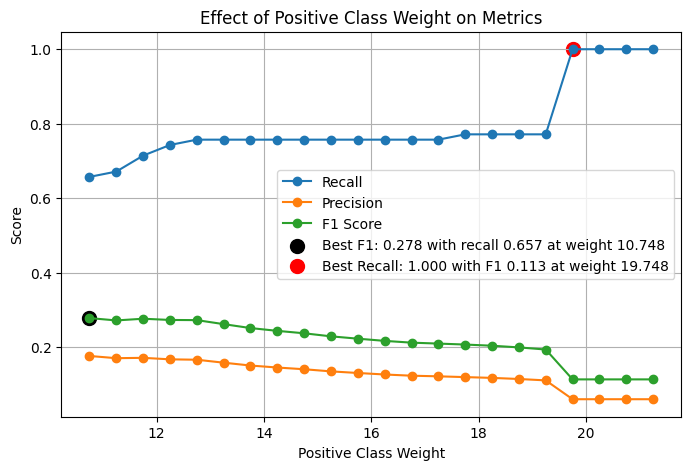

In [ ]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

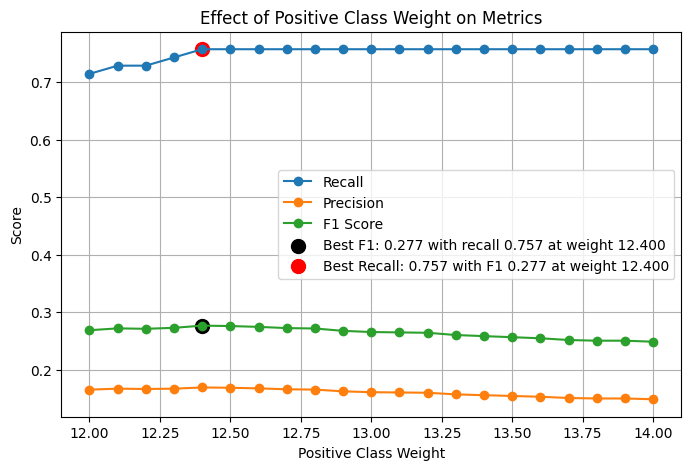

In [ ]:
weights_to_test = np.arange(12, 14 + 0.1, 0.1)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test)

In [333]:
w, b = logisticRegression.logistic_regression(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=learning_rate_optimized, extra_weight=12.4, iterations=1000)
f1_threshold_2, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w, b )
model = Model.Model(w,b,f1_threshold_2, improvement="Added diff mid-low educ")
MODEL_V1_1_DIFF_EDUC = "ModelV1_with_diff_educ"
tracker.add(model, name=MODEL_V1_1_DIFF_EDUC)

logisticRegression.print_model_stats(X_val_np, y_val_np, w,b,f1_threshold_2)

Iteration 0: Train cost = 1.1650 | Val cos =  0.6931
Iteration 100: Train cost = 1.0165 | Val cos =  0.5259
Iteration 200: Train cost = 0.9975 | Val cos =  0.5169
Iteration 300: Train cost = 0.9866 | Val cos =  0.5128
Iteration 400: Train cost = 0.9791 | Val cos =  0.5105
Iteration 500: Train cost = 0.9733 | Val cos =  0.5088
Iteration 600: Train cost = 0.9685 | Val cos =  0.5076
Iteration 700: Train cost = 0.9644 | Val cos =  0.5065
Iteration 800: Train cost = 0.9606 | Val cos =  0.5055
Iteration 900: Train cost = 0.9572 | Val cos =  0.5047
Model ModelV1_with_diff_educ saved

Accuracy:  0.9098712446351931
[[1037   58]
 [  47   23]]
AUC: 0.7946
F1: 0.3046


Si on compare aux variables précédentes on a

In [334]:
X_train_old, X_val_old, y_train_old, y_val_old = data_tracker.get(DATA_V1, split=True, toNpy=False)

float_cols = X.columns[X.dtypes == 'float64']

scaler = StandardScaler()
scaler.fit(X_train_old[float_cols])
X_train_old[float_cols] = scaler.transform(X_train_old[float_cols])
X_val_old[float_cols] = scaler.transform(X_val_old[float_cols])


X_train_old_np = X_train_old.to_numpy()
X_val_old_np = X_val_old.to_numpy()
y_train_old_np = y_train_old.to_numpy()
y_val_old_np = y_val_old.to_numpy()


prevModel = tracker.get_by_name(MODEL_V1)

print("Model V1 on old data:")
logisticRegression.print_model_stats(X_val_old_np, y_val_old_np, prevModel.w, prevModel.b, f1_threshold)

print("\nModel V1.1 with diff educ:")
logisticRegression.print_model_stats(X_val_np, y_val_np, model.w, model.b, f1_threshold_2)


Model V1 on old data:
Accuracy:  0.8918454935622318
[[1012   83]
 [  43   27]]
AUC: 0.7965
F1: 0.3000

Model V1.1 with diff educ:
Accuracy:  0.9098712446351931
[[1037   58]
 [  47   23]]
AUC: 0.7946
F1: 0.3046


In [359]:
lambda_values = np.array([900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400])
logisticRegression.find_best_lambda(lambda_values, X_train_np, y_train_np, X_val_np, y_val_np, extra_weight=12.4, iterations=1000)

Lambda: 900.000000 | Best T: 0.630 | F1: 0.3085
Lambda: 950.000000 | Best T: 0.630 | F1: 0.3085
Lambda: 1000.000000 | Best T: 0.630 | F1: 0.3102
Lambda: 1050.000000 | Best T: 0.630 | F1: 0.3118
Lambda: 1100.000000 | Best T: 0.630 | F1: 0.3152
Lambda: 1150.000000 | Best T: 0.630 | F1: 0.3152
Lambda: 1200.000000 | Best T: 0.630 | F1: 0.3187
Lambda: 1250.000000 | Best T: 0.630 | F1: 0.3187
Lambda: 1300.000000 | Best T: 0.630 | F1: 0.3187
Lambda: 1350.000000 | Best T: 0.630 | F1: 0.3204
Lambda: 1400.000000 | Best T: 0.630 | F1: 0.3204

Best lambda: 1350
Best threshold: 0.630
Best F1: 0.3204


(np.int64(1350), 0.32044198895027626)

J'ai l'impression que le modèle vise beaucoup trop une classe particulière, j'ai fix mon L2 reg et maintenant j'ai des résultats un peu mieux. Deux targets de plus et un FN de moins comparer à model V1

In [361]:
lambda_const = 1350
best_thresh = 0.63
w, b = logisticRegression.logistic_regression(
    X_train_np, y_train_np, X_val_np, y_val_np, 
    learning_rate=learning_rate_optimized, 
    l2_reg=True, lambda_const=lambda_const,
    extra_weight=12.4, iterations=1000)


print("Model V1 on old data:")
logisticRegression.print_model_stats(X_val_old_np, y_val_old_np, prevModel.w, prevModel.b, f1_threshold)

print("\nModel V1.1 with L2 regularization:")
logisticRegression.print_model_stats(X_val_np, y_val_np, w, b, best_thresh)

Iteration 0: Train cost = 1.1650 | Val cos =  0.6931
Iteration 100: Train cost = 1.0267 | Val cos =  0.5310
Iteration 200: Train cost = 1.0161 | Val cos =  0.5241
Iteration 300: Train cost = 1.0120 | Val cos =  0.5214
Iteration 400: Train cost = 1.0099 | Val cos =  0.5201
Iteration 500: Train cost = 1.0088 | Val cos =  0.5193
Iteration 600: Train cost = 1.0081 | Val cos =  0.5188
Iteration 700: Train cost = 1.0077 | Val cos =  0.5185
Iteration 800: Train cost = 1.0074 | Val cos =  0.5183
Iteration 900: Train cost = 1.0073 | Val cos =  0.5182
Model V1 on old data:
Accuracy:  0.8918454935622318
[[1012   83]
 [  43   27]]
AUC: 0.7965
F1: 0.3000

Model V1.1 with L2 regularization:
Accuracy:  0.894420600858369
[[1013   82]
 [  41   29]]
AUC: 0.8024
F1: 0.3204


Comme vu précédement, le modèle est probablement en train de classifier les acheteurs selon leurs richesses. 

In [412]:
y_pred= logisticRegression.predict(X_val_np, w, b, f1_threshold)

tp_indices = np.where((y_val_np == 1) & (y_pred == 1))[0]
fp_indices = np.where((y_val_np == 1) & (y_pred == 0))[0]
tn_indices = np.where((y_val_np == 0) & (y_pred == 0))[0]
fn_indices = np.where((y_val_np == 0) & (y_pred == 1))[0]
X_tp = X_val_np[tp_indices]
X_fp = X_val_np[fp_indices]
X_tn = X_val_np[tn_indices]
X_fn = X_val_np[fn_indices]
X_tp_df = pd.DataFrame(data=X_tp, columns=X_val.columns)
X_fp_df = pd.DataFrame(data=X_fp, columns=X_val.columns)
X_tn_df = pd.DataFrame(data=X_tn, columns=X_val.columns)
X_fn_df = pd.DataFrame(data=X_fn, columns=X_val.columns)

0       0
1       0
2       0
3       0
4       0
       ..
5816    0
5817    0
5818    1
5819    0
5820    0
Name: CARAVAN, Length: 5821, dtype: int64

MAANTHUI                   True
MGEMOMV                    True
MGEMLEEF                   True
MGODRK                     True
MGODPR                     True
                           ... 
MOSTYPE_12_x_MBERARBO_0    True
MOSTYPE_12_x_MBERARBO_2    True
MOSTYPE_36_x_MBERARBO_4    True
MOSTYPE_38_x_MBERARBO_0    True
MOSTYPE_38_x_MBERARBO_3    True
Length: 175, dtype: bool


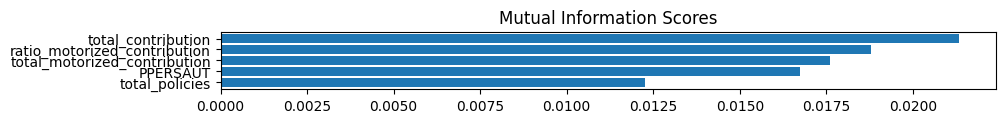

In [477]:
discrete_features = X.drop('CARAVAN', axis=1).dtypes == int
mi = feature_tools.make_mi_scores(X.drop('CARAVAN', axis=1), X['CARAVAN'], discrete_features)
mi = mi[mi > 0.001]
feature_tools.plot_mi_scores(mi.head(5))

On peut voir que la grande majorité des FN et TP ont une total_contribution > 10. Aussi selon le score Mutual information, total_contribution est celui qui a scorer le plus haut. Le modèle est peut-etre biaiser pour eux.

Si on regarde 

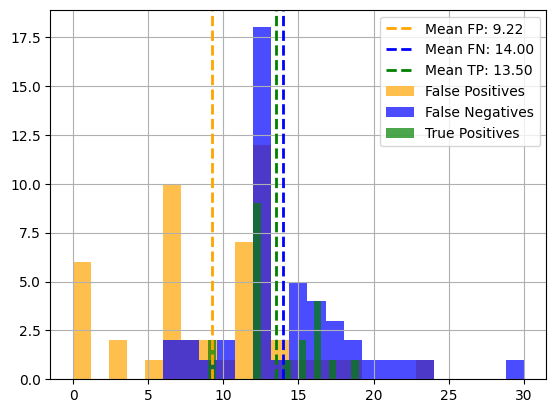

In [ ]:
# X_tn_df['total_contribution'].hist(bins=30,label='True Negatives')

mean_fp = X_fp_df['total_contribution'].mean()
mean_fn = X_fn_df['total_contribution'].mean()
mean_tp = X_tp_df['total_contribution'].mean()

median_fp = X_fp_df['total_contribution'].median()
median_fn = X_fn_df['total_contribution'].median()
median_tp = X_tp_df['total_contribution'].median()

plt.axvline(mean_fp, color='orange', linestyle='dashed', linewidth=2, 
            label=f'Mean FP: {mean_fp:.2f}')
plt.axvline(mean_fn, color='blue', linestyle='dashed', linewidth=2, 
            label=f'Mean FN: {mean_fn:.2f}')
plt.axvline(mean_tp, color='green', linestyle='dashed', linewidth=2, 
            label=f'Mean TP: {mean_tp:.2f}')

X_fp_df['total_contribution'].hist(bins=20, alpha=0.7,label='False Positives', color='orange')
X_fn_df['total_contribution'].hist(bins=20, alpha=0.7,label='False Negatives', color='blue')
X_tp_df['total_contribution'].hist(bins=20, alpha=0.7,label='True Positives', color='green')
plt.legend();

In [389]:
L0 = data.get_dict("L0")

# Replace codes with labels for both groups
mostype_1 = df[df['CARAVAN'] == 1]['MOSTYPE'].map(L0).value_counts()
mostype_0 = df[df['CARAVAN'] == 0]['MOSTYPE'].map(L0).value_counts()

# Combine into one DataFrame
side_by_side = pd.DataFrame({
    "CARAVAN = 1": mostype_1,
    "CARAVAN = 0": mostype_0
}).fillna(0).astype(int)

side_by_side.sort_values(by="CARAVAN = 1", ascending=False)

,CARAVAN = 1,CARAVAN = 0
MOSTYPE,,
Middle class families,51,288
Lower class large families,46,763
High status seniors,25,224
Traditional families,23,316
Large religous families,19,309
Couples with teens 'Married with children',16,209
Affluent young families,16,95
Young all american family,13,166
"High Income, expensive child",13,111


In [397]:
profiles = [profile_tp, profile_fp, profile_tn, profile_fn]
profile_names = ['True Positives (TP)', 'False Positives (FP)', 'True Negatives (TN)', 'False Negatives (FN)']
import re

for i, profile in enumerate(profiles):

    # --- 0. Apply MOSTYPE renaming before filtering ---
    profile.index = [
        data.apply_Lx_to_index(idx, name="MOSTYPE", level='L0')
        for idx in profile.index
    ]

    # --- 1. Now detect rows that START with a MOSTYPE label ---
    # We look for any renamed index that used to be MOSTYPE
    mostype_index = [
        idx for idx in profile.index
        if not idx.startswith("MOSTYPE")  
        and any(char.isalpha() for char in idx)  # renamed labels are words
    ]

    # If you want a safer version:
    # mostype_index = [idx for idx in profile.index if "MOSTYPE" not in idx]

    mostype_data = profile.loc[mostype_index]

    # --- Print results ---
    print(f"\n### Profil : {profile_names[i]} ###")
    print(mostype_data.to_markdown())
    print("-" * 70)
    


### Profil : True Positives (TP) ###
|                                                         |          0 |
|:--------------------------------------------------------|-----------:|
| total_contribution                                      | 13.5833    |
| MRELGE                                                  |  7.29167   |
| MHKOOP                                                  |  7.20833   |
| MAUT1                                                   |  6.70833   |
| total_motorized_contribution                            |  6.33333   |
| MKOOPKLA                                                |  6.08333   |
| PPERSAUT                                                |  6         |
| MGODPR                                                  |  5.58333   |
| MFWEKIND                                                |  4.875     |
| MBERMIDD                                                |  4.45833   |
| PBRAND                                                  |  4         |
| total_polic

In [378]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

tp_html = profile_tp.head(30).to_frame().to_html()
fp_html = profile_fp.head(30).to_frame().to_html()
tn_html = profile_tn.head(30).to_frame().to_html()
fn_html = profile_fn.head(30).to_frame().to_html()

HTML(f"""
<div style="display:flex; gap:20px; flex-wrap:wrap">

    <div>
        <h3 style="text-align:center;">True Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tn_df)}</p>
        {tn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Negatives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fn_df)}</p>
        {fn_html}
    </div>

    <div>
        <h3 style="text-align:center;">False Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_fp_df)}</p>
        {fp_html}
    </div>

    <div>
        <h3 style="text-align:center;">True Positives</h3>
        <p style="text-align:center; margin-top:-10px;">Count: {len(X_tp_df)}</p>
        {tp_html}
    </div>

</div>
""")

,0
MRELGE,6.102639
total_contribution,5.937439
MAUT1,5.899316
MGODPR,4.585533
MHKOOP,4.578690
MFWEKIND,4.267840
MKOOPKLA,4.097752
MSKC,3.792766
MGODGE,3.309873
MFGEKIND,3.243402


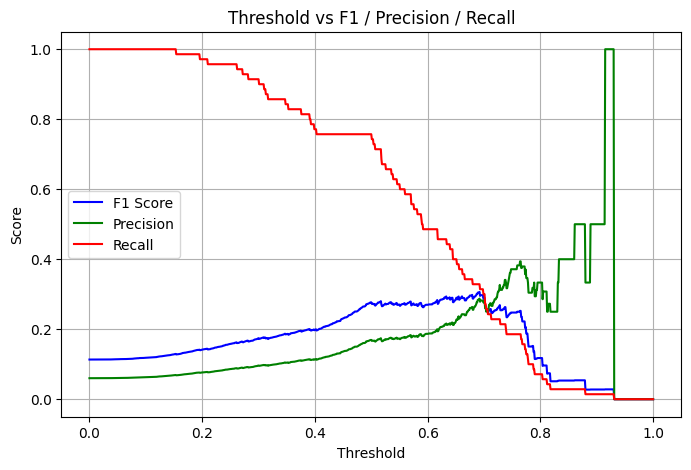

In [ ]:
plot_tools.plot_threshold_metrics(model, X_val_np, y_val_np, step=0.001)

In [ ]:
profile_tp = X_tp_df.mean().sort_values(ascending=False)
profile_fp = X_fp_df.mean().sort_values(ascending=False)
profile_tn = X_tn_df.mean().sort_values(ascending=False)
profile_fn = X_fn_df.mean().sort_values(ascending=False)

display(X_tp_df.describe())

display(X_fp_df.describe())

In [ ]:
import matplotlib
from IPython.display import HTML
import pandas as pd

# Colonnes d'intérêt
cols = ['MOPLLAAG', 'MOPLMIDD', 'MOPLHOOG']

df_profiles = pd.DataFrame({
    'Category': ['TN', 'FN', 'FP', 'TP'],
})

# Ajouter chaque colonne
for col in cols:
    df_profiles[col] = [
        profile_tn[col],
        profile_fn[col],
        profile_fp[col],
        profile_tp[col]
    ]

# Ajouter les colonnes Moyennes
df_profiles['Moyenne'] = df_profiles[cols].mean(axis=1)
df_profiles['Moyenne_2'] = df_profiles[['MOPLLAAG', 'MOPLMIDD']].mean(axis=1)
df_profiles['Diff_MID_LLAAG'] = df_profiles['MOPLMIDD'] - df_profiles['MOPLLAAG']  # nouvelle colonne

# Fonction pour coloriser par ligne (row-wise)
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    
    def f(val):
        cmap = matplotlib.colormaps["YlOrRd"]
        rgba = cmap(norm(val))
        return f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]}); color: black;'
    
    return [f(val) for val in row]

# Colonnes numériques pour la heatmap
numeric_cols = cols + ['Moyenne', 'Moyenne_2', 'Diff_MID_LLAAG']

# Appliquer le style
styler = df_profiles.style.apply(colorize_row, axis=1, subset=numeric_cols) \
                          .set_table_attributes('style="border-collapse:collapse; width:80%;"')

# Générer le code HTML
html_code = styler.to_html()
print(html_code)


In [ ]:
import matplotlib
from IPython.display import HTML
import pandas as pd

# New columns to include
cols = ['MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD']

# Create a new DataFrame for the profiles
df_profiles = pd.DataFrame({
    'Category': ['TN', 'FN', 'FP', 'TP'],
})

# Add each column from cols
for col in cols:
    df_profiles[col] = [
        profile_tn[col],
        profile_fn[col],
        profile_fp[col],
        profile_tp[col]
    ]

# Add the new average columns
df_profiles['Moyenne'] = df_profiles[cols].mean(axis=1)
df_profiles['Moyenne_B1B2C'] = df_profiles[['MSKB1', 'MSKB2', 'MSKC']].mean(axis=1)
df_profiles['Moyenne_B1B2'] = df_profiles[['MSKB1', 'MSKB2']].mean(axis=1)

# Function to colorize row-wise
def colorize_row(row):
    row_min = row.min()
    row_max = row.max()
    norm = matplotlib.colors.Normalize(vmin=row_min, vmax=row_max)
    
    def f(val):
        cmap = matplotlib.colormaps["YlOrRd"]
        rgba = cmap(norm(val))
        return f'background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]}); color: black;'
    
    return [f(val) for val in row]

# Apply the style to all numeric columns
numeric_cols = cols + ['Moyenne', 'Moyenne_B1B2C', 'Moyenne_B1B2']
styler = df_profiles.style.apply(colorize_row, axis=1, subset=numeric_cols) \
                          .set_table_attributes('style="border-collapse:collapse; width:90%;"')

# Generate HTML
html_code = styler.to_html()
print(html_code)


Je vais commencer par ajouter une nouvelle variable, car elle semble prometeuse. \
diff_edu_mid_bas

In [ ]:
X_

In [ ]:
model = Model.Model(w,b,f1_threshold, improvement="Model V1")
MODEL_V1 = "modelV1"
tracker.add(model, name=MODEL_V1)
tracker.set_preferred(MODEL_V1)

Model modelV1 existe deja, overriding...
Model modelV1 saved

Model modelV1 is now preferred.


J'ai l'impression que le modèle a atteint sa limite.

In [ ]:
sklearn_model = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=10000, class_weight='balanced', random_state=42)
sklearn_model.fit(X_train_np, y_train_np)
w_sklearn = sklearn_model.coef_[0]
b_sklearn = sklearn_model.intercept_[0]

f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_np, y_val_np, w_sklearn, b_sklearn )

y_pred_proba_sk = sklearn_model.predict_proba(X_val_np)[:, 1]
y_pred_optimal_val = (y_pred_proba_sk >= f1_threshold).astype(int)


# Affichage des métriques finales (avec le seuil optimal)
from sklearn.metrics import confusion_matrix
print("\n--- Métriques SKLearn avec Seuil Optimal ---")
print(f"F1-thres : {f1_threshold:.4f}")
print(f"Matrice de Confusion:\n{confusion_matrix(y_val_np, y_pred_optimal_val)}")
#print(f"AUC: {roc_auc_score(y_val_np, y_pred_proba_sk):.4f}")
print(f"F1-Score: {f1_score(y_val_np, y_pred_optimal_val):.4f}")


--- Métriques SKLearn avec Seuil Optimal ---
F1-thres : 0.8200
Matrice de Confusion:
[[1031   64]
 [  49   21]]
F1-Score: 0.2710


Je vais re-évaluer les class weights pour affiner le modèle, puisque maintenant que j'ai optimisé les poids 

Maintenant nombre iter optimal

In [ ]:
print(f1_scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
categorical_vars, discrete_vars = data.get_var_by_types(df)
discrete_vars.remove('CARAVAN')

df_encoded = pd.get_dummies(df, columns=categorical_vars, prefix=categorical_vars, dtype=int)
print(df_encoded.dtypes)


MAANTHUI       int64
MGEMOMV        int64
MGEMLEEF       int64
MGODRK         int64
MGODPR         int64
               ...  
MOSHOOFD_6     int64
MOSHOOFD_7     int64
MOSHOOFD_8     int64
MOSHOOFD_9     int64
MOSHOOFD_10    int64
Length: 134, dtype: object


(2025-11-12)
J'ai oublier de one-hot code les variables MOSHOOFD et MOSTYPE. Elles sont categorique, mais pas ordinale. Mes résultats sont pas mal différents maintenant.

In [ ]:
X = df_encoded.drop('CARAVAN', axis=1) 
y = df_encoded['CARAVAN']  #targets

X_train, X_val, y_train, y_val = data.get_split_train_eval_data(df_encoded)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()

In [ ]:
w,b = logisticRegression.logistic_regression(X_train_np, y_train_np)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.2153636686007336
Iteration 200: Cost = 0.21049395901189405
Iteration 300: Cost = 0.2080377100140786
Iteration 400: Cost = 0.20659973578995863
Iteration 500: Cost = 0.2056581102317727
Iteration 600: Cost = 0.20498405318644572
Iteration 700: Cost = 0.20446697987594464
Iteration 800: Cost = 0.20404888252915485
Iteration 900: Cost = 0.20369711341448316


In [ ]:
threshold = 0.1 #trop bas
model = Model.Model(w, b, threshold)
tracker.add(model)
model.print_stats(X_val_np, y_val_np)

Model v1 saved

Threshold:  0.1
Accuracy:  0.8171673819742489
[[915 180]
 [ 33  37]]
AUC:  0.7950554468362687


Présentement le modèle est vraiment pas bon. Même avec un threshold de 0.1, il prédit seulement 37 qui ont besoin d'une assurance caravan en plus avec un threshold de seulement 0.1

In [ ]:
print(np.bincount(y_train_np))

[4378  278]


La classe est imbalanced.

Vu que la majoriter est "pas besoin d'assurance caravan", le modèle apprend probablement plutot a prédire: qui n'a pas besoin d'assurance caravan.

Donc je vais ajuster les weights pour que lorsque le modèle prédit incorrectement que quelqu'un a pas besoin d'assurance Caravan et qu'il ai tord, il sera pénaliser x fois plus. Comme ça, il va faire plus attention à eux que ceux qui n'ont pas besoin d'assurance caravan.

In [ ]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, extra_weight=ratio)

Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 1.1388425304646177
Iteration 200: Cost = 1.121400976538757
Iteration 300: Cost = 1.1121657182285678
Iteration 400: Cost = 1.1055838711931845
Iteration 500: Cost = 1.1003761326917096
Iteration 600: Cost = 1.0960261871506227
Iteration 700: Cost = 1.0922736028266518
Iteration 800: Cost = 1.0889671847594784
Iteration 900: Cost = 1.086010076352683


In [ ]:
print(ratio)

15.748201438848922


Pour choisir le poid additionnel, je vais choisir le multiple qui donne le plus haut recall mais sans trop baisser le F1 score. J'aimerais maximiser le nombre de client potentiel, donc un recall élevé avec un F1 score/précision légèrement plus bas est préférable.

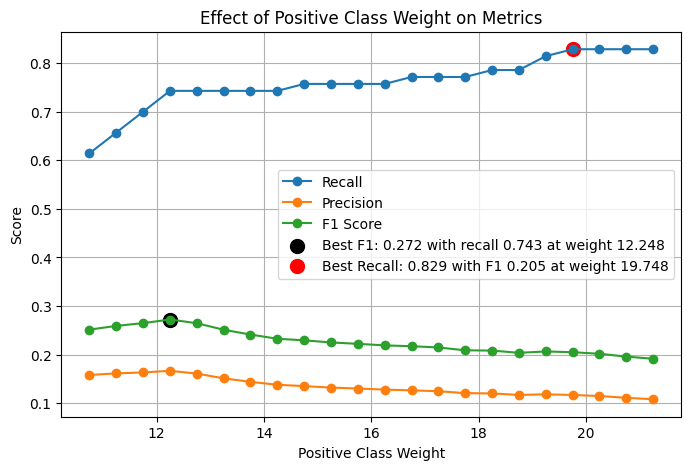

In [ ]:
weights_to_test = np.arange(ratio - 5, ratio + 5 + 0.5, 0.5)

plot_tools.plot_weights_effects(X_train_np, y_train_np, X_val_np, y_val_np, 0.5, weights_to_test, learning_rate=0.01)

Pour l'instant je vais garder le poid additionnel

<s>Le cout augmente, donc peut-être le learning rate est trop grand. Je vais l'ajuster.</s>

Pour trouver le learning rate optimal, je peux check quel learning rate donne la meilleure balance entre un bon F1 score et un cost function bas. C'est pas forcément celui où la loss est la plus basse ou le F1 est le plus haut, mais celui ou il y a une bonne balance entre les deux.

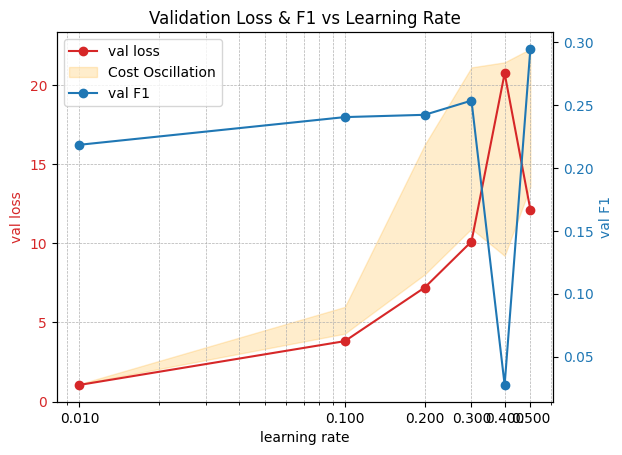

In [ ]:
lrs = np.array([0.01,0.1, 0.2, 0.3, 0.4, 0.5])
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, toPlot=True, iterations=500, extra_weight=ratio)

In [ ]:
print(val_losses)

[np.float64(20.753900159947033), np.float64(10.117057651472667), np.float64(7.210948584760829)]


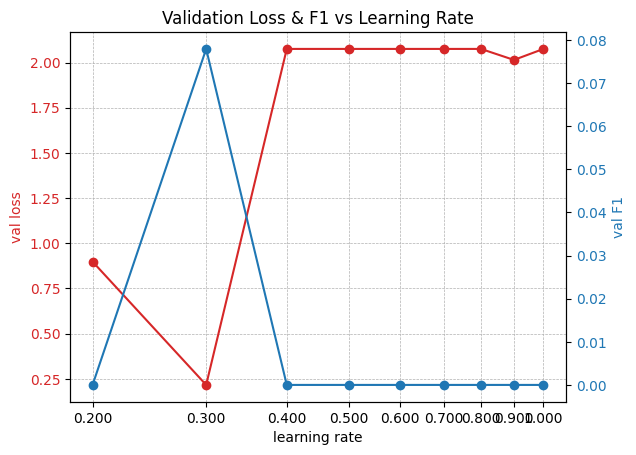

In [ ]:
lrs = np.array([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2])
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, toPlot=True, iterations=500)

In [ ]:
print(val_f1s)

[0.0, 0.02702702702702703, 0.0, 0.0]


Après avoir fix l'erreur du sigmoid qui overflow (dans exp(z)), j'obtiens des résultats complètements différents...

On peut voir que la meilleure balance offerte est clairement autour d'un learning rate de 0.3. 
- Avant 0.3, le score F1 est bas, avec un coût bas. 
- Après 0.3, le modèle devient instable, le coût varie et F1 chute.

Aussi le cout plus bas en 0.3 et 0.2 est normal. Le cout ne varie pas linéairement. Un learning rate trop petit peut coincer le modèle lors de son entrainement, car il n'arrive pas a surmonter un minimum local et donc sa peut causer une augmentation du cout puisqu'il reste coincer plus haut. Un learning rate optimale stabilise la descente vers un minimum global.

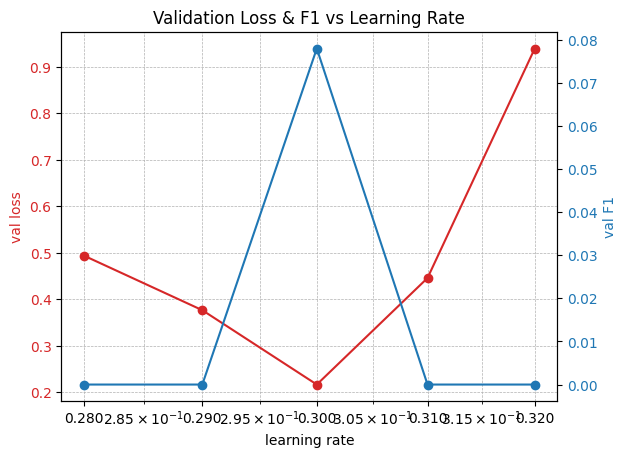

In [ ]:
lrs = np.array([0.28, 0.29, 0.3, 0.31, 0.32])
val_losses, val_f1s = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, toPlot=True, iterations=500)

In [ ]:
print(val_f1s)

[0.0, 0.0, 0.07792207792207792, 0.0, 0.0]


0.3 est un le sweet spot.

In [ ]:
learning_rate = 0.3

Maintenant, je vais trouver le nombre d'itérations optimal.

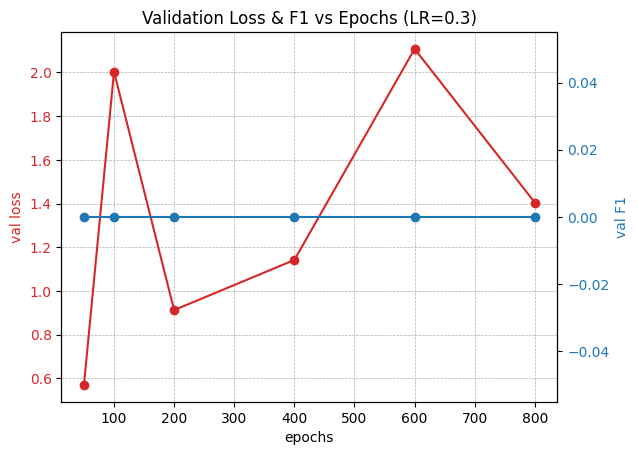

In [ ]:
epochs_list = [50, 100, 200, 400, 600, 800]
val_losses, f1_scores = plot_tools.epochs_grid_search(
    X_train_np, y_train_np, X_val_np, y_val_np,
    epochs_list, learning_rate=learning_rate
)

In [ ]:
print(f1_scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

learning_rate=learning_rate

w,b = logisticRegression.logistic_regression(X_train_np, y_train_np, iterations=1000, extra_weight=ratio, learning_rate=0.3)

Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 11.025588656409333
Iteration 200: Cost = 11.669417821625473
Iteration 300: Cost = 10.97425346667837
Iteration 400: Cost = 11.991234643853907
Iteration 500: Cost = 11.14037589059247
Iteration 600: Cost = 14.121543536487126
Iteration 700: Cost = 12.549552464806338
Iteration 800: Cost = 11.26285324721419
Iteration 900: Cost = 12.982785073132654


In [ ]:
threshold = 0.5 #trop bas
model = Model.Model(w, b, threshold, improvement="adjusted weights")
tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v4 saved

adjusted weights

Threshold:  0.5
Accuracy:  0.9072961373390558
[[1037   58]
 [  50   20]]
AUC:  0.7760078277886497


C'est déja mieux, mais le threshold est trop bas. Je vais essayer 0.5

In [ ]:
threshold = 0.5
model = Model.Model(w, b, threshold, improvement="adjusted weights")
tracker.add(model)

model.print_stats(X_val_np, y_val_np)

Model v12 saved

adjusted weights

Threshold:  0.5
Accuracy:  0.6815450643776824
[[741 354]
 [ 17  53]]
AUC:  0.7884148727984346


Beaucoup mieux, en plus avec un threshold de 0.5. Donc je croit, le modèle est asser précis maintenant. Je vais chercher le meilleur threshold.

In [ ]:
threshold = logisticRegression.get_youden_threshold(X_val_np, y_val_np, w, b)
model = Model.Model(w, b, threshold, improvement="Youden index threshold")

YOUDEN_MODEL = "YoudenModel"
tracker.add(model, name=YOUDEN_MODEL, set_preferred=True)
model.print_stats(X_val_np, y_val_np)

Model YoudenModel existe deja, overriding...
Model YoudenModel saved

Youden index threshold

Threshold:  0.5638292284742521
Accuracy:  0.7570815450643776
[[832 263]
 [ 20  50]]
AUC:  0.7844618395303327


Au faite non, il n'est pas asser précis. Il a 313 False positive, donc il prédit 313 personnes comme ayant besoin d'assurance caravan en faite que non, ils ont pas besoin. En plus, il manque pas mal de personne (17) qui ont actually besoin d'une assurance caravan. 

In [ ]:
data.top_index_and_values(15 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799
High level education                               MOPLHOOG   - 0.0782
1 car                                              MAUT1      - 0.0734
Income 45-75.000                                   MINK4575   - 0.0699
Number of fire policies                            ABRAND     - 0.0695
Number

On voit que PPERSAUT & APERSAUT sont les variables qui corrèles le plus avec CARAVAN, ce qui fais du sens puisque pour utiliser une Caravan, il faut au minimum une voiture pour la remorquer. 
- Donc, je pourrais indiquer à mon modèle qui si la personne a aucune voiture, alors c'est un "pas besoin d'assurance caravan" ou tout simplement les retirer du dataset. (C'est mieux de pas retirer, car sinon il pourrait miss des patterns et mal classifiés des personnes plus tard)

De plus, APLEZIER, PPLEZIER et PBRAND nous dit que les personnes qui ont des caravans sont des personnes avec un bon income, c'est surtout des clients disposant d’un pouvoir d’achat élevé.
- Donc, s'il y a moyen, peut-etre d'indiquer au modèle de faire plus attention a eux?

Je peux ajouter des "interaction terms". Pour PPERSAUT et APERSAUT c'est parfait puisque l'effet de PPERSAUT sur la probabilité d'avoir besoin d'une assurance caravan, dépend de APERSAUT (ou en d'autre mots dépend du nombre de car policies).

In [ ]:
vars_to_test = [
    'PPERSAUT',   # Contribution car policies
    'APERSAUT',   # Number of car policies
    'APLEZIER',   # Number of boat policies
    'PPLEZIER',   # Contribution boat policies
    'PBRAND',     # Contribution fire policies
    'MINKGEM',    # Average income
    'PWAPART',    # Contribution private third party insurance see L4 
    'MKOOPKLA',   # Purchasing power class
    'AWAPART',    # Number of private third party insurance 1 - 12 
    'MHKOOP'      # Home owners
]

logisticRegression.interactions_terms_tester(X_train, y_train_np, w, b, vars_to_test=vars_to_test, learning_rate=0.005, ratio=ratio)

Interaction PPERSAUT_x_APERSAUT : AUC = 0.7559 (gain = +0.0010)
Interaction PPERSAUT_x_APLEZIER : AUC = 0.7606 (gain = +0.0057)
Interaction PPERSAUT_x_PPLEZIER : AUC = 0.7604 (gain = +0.0055)
Interaction PPERSAUT_x_PBRAND : AUC = 0.7599 (gain = +0.0050)
Interaction PPERSAUT_x_MINKGEM : AUC = 0.7551 (gain = +0.0002)
Interaction PPERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0020)
Interaction PPERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction PPERSAUT_x_AWAPART : AUC = 0.7560 (gain = +0.0011)
Interaction PPERSAUT_x_MHKOOP : AUC = 0.7562 (gain = +0.0013)
Interaction APERSAUT_x_APLEZIER : AUC = 0.7552 (gain = +0.0003)
Interaction APERSAUT_x_PPLEZIER : AUC = 0.7562 (gain = +0.0014)
Interaction APERSAUT_x_PBRAND : AUC = 0.7593 (gain = +0.0044)
Interaction APERSAUT_x_MINKGEM : AUC = 0.7553 (gain = +0.0004)
Interaction APERSAUT_x_PWAPART : AUC = 0.7568 (gain = +0.0019)
Interaction APERSAUT_x_MKOOPKLA : AUC = 0.7550 (gain = +0.0001)
Interaction APERSAUT_x_AWAPART : AUC = 0.7555 (gain

Je vais commencer par ajouter tout les interactions qui ont au minimum +0.003 de gain. 
Donc, PPERSAUT_x_APLEZIER, PPERSAUT_x_PPLEZIER, PPERSAUT_x_PBRAND, APERSAUT_x_PBRAND, PPLEZIER_x_MINKGEM, PPLEZIER_x_MKOOPKLA, PPLEZIER_x_MHKOOP.

In [ ]:
interactions_to_add_1 = [
    ("PPERSAUT", "APLEZIER"),
    ("PPERSAUT", "PPLEZIER"),
    ("PPERSAUT", "PBRAND"),
    ("APERSAUT", "PBRAND"),
    ("APLEZIER", "MINKGEM"),
    ("APLEZIER", "MHKOOP"),
    ("PPLEZIER", "MINKGEM"),
    ("PPLEZIER", "MKOOPKLA"),
    ("PPLEZIER", "MHKOOP"),
]

X_train_final = data.add_interactions_terms(X_train, interactions_to_add_1)
X_val_final = data.add_interactions_terms(X_val, interactions_to_add_1)

X_train_final_np = X_train_final.to_numpy()
X_val_final_np = X_val_final.to_numpy()

prev_model = tracker.get_by_name(YOUDEN_MODEL)

model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, improvement="Added interactions terms with auc gain > 0.003", extra_weight=ratio, learning_rate=learning_rate, threshold_method="Youden")
print("With training set :")
logisticRegression.compare_auc_score(X_train_np, y_train_np, X_train_final_np, prev_model, model)

With training set :
New X : AUC = 0.7863 (gain = +0.0111)


Les intéractions ont ajoutés un gain d'AUC considérable (+1.24%)! Je vais faire un overfitting test pour voir s'il suraprenti pas.


In [ ]:
X_train_interaction_1 = X_train_final
X_val_interaction_1 = X_val_final
logisticRegression.compare_model_stats(X_val_np, y_val_np, prev_model, model, X_val_final_np, isValData=True)

(Avec val data)

Old model :
Youden index threshold

Threshold:  0.23538129822899068
Accuracy:  0.7656652360515022
[[842 253]
 [ 20  50]]
AUC:  0.7808610567514676

New model :
Added interactions terms with auc gain > 0.003

Threshold:  0.40544097808164664
Accuracy:  0.7356223175965665
[[803 292]
 [ 16  54]]
AUC:  0.7797390737116765


<s>Sur le val data, les deux modèles détectent presque autant de vrais acheteurs. Par contre le nouveau modèle est considérablement plus précis en général. Je crois qu'il est plus avantageux de garder le nouveau modèle du au gain significatif de précision et que la perte des targets est seulement de 10.</s>

Maintenant, après avoir corrigé l'erreur d'utiliser le full training set pour évaluer et train le modèle et ensuite re-évaluer avec le test set. J'obtiens des résultats différents. Maintenant, le modèle est moins précis, mais son score AUC a augmenté d'environ 2%, donc il est plus facile pour lui de discriminer entre eux qui ont besoin d'assurance caravan vs eux que non. Malgré la perte de précision, je crois que dans ce cas si, c'est mieux de garder le nouveau modèle, car il discrimine mieux entre les targets et les non-targets.

In [ ]:
INTER_TERMS_1_MODEL = "inter_terms_1" 
tracker.add(model, name=INTER_TERMS_1_MODEL, set_preferred=True)

Model inter_terms_1 saved



Maintenant, je vais voir si ajouter les interactions de termes qui ont un gain d'au moins 0.002 marche bien. Donc : PPERSAUT_x_PWAPART, APLEZIER_x_MKOOPKLA, APLEZIER_x_PPLEZIER

In [ ]:
interactions_to_add_2 = [
    ('PPERSAUT', 'PWAPART'),
    ("APLEZIER", "MKOOPKLA"),
    ("APLEZIER", "PPLEZIER"),
]

X_train_final = data.add_interactions_terms(X_train_interaction_1, interactions_to_add_2)
X_train_final_np = X_train_final.to_numpy()

X_val_final = data.add_interactions_terms(X_val_interaction_1, interactions_to_add_2)
X_val_final_np = X_val_final.to_numpy()

prev_model = tracker.get_by_name(INTER_TERMS_1_MODEL)

model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, improvement="Added interactions terms with auc gain > 0.002", extra_weight=ratio, learning_rate=learning_rate, threshold_method="Youden")
logisticRegression.compare_auc_score(X_train_interaction_1.to_numpy(), y_train_np, X_train_final_np, prev_model, model)

New X : AUC = 0.7856 (gain = -0.0007)


In [ ]:
INTER_TERMS_2_MODEL = "inter_terms_2" 
tracker.add(model, name=INTER_TERMS_2_MODEL)
logisticRegression.compare_model_stats(X_val_interaction_1.to_numpy(), y_val_np, prev_model, model, X_val_final_np, isValData=True)

Model inter_terms_2 saved

(Avec val data)

Old model :
Added interactions terms with auc gain > 0.003

Threshold:  0.40544097808164664
Accuracy:  0.7356223175965665
[[803 292]
 [ 16  54]]
AUC:  0.7797390737116765

New model :
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145


<s> Le modèle augmente le rappel mais au cout de la précision. Je ne crois pas que sa vaut la peine, car la perte de précision est asser importante. </s>

<s>Les changements sont très faibles. Je ne vais pas ajouter les nouvelles intéractions pour éviter des complexifier le modèle inutilement. </s>

<s> Au faites, les changements sont faibles oui, mais pour le score AUC. Si on regarde la précision, il y eu un gain asser important. Environ (+1.3% de précision) et il trouve 1 target de plus. Je crois que sa vaut la peine de garder les termes additionneles pour l'instant.</s>

Oops je crois j'ai inversé le "il trouve 1 target de plus", mais je crois que le gain en précision de 1.3% est un bon échange pour une perte de 1 target.

In [ ]:
#À garder pour plus tard au cas ou.
X_train_interaction_2 = X_train_final_np
X_val_interaction_2 = X_val_final_np

tracker.set_preferred(INTER_TERMS_2_MODEL)
model.print_stats(X_val_final_np, y_val_np)

Model inter_terms_2 is now preferred.
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145


Je vais ajouter un L2 regularization pour pénaliser l'overfitting (surapprentissage), car j'ai ajouté des interactions terms. De plus,  L2 regularization encourage les weights à réduire leur magnitude, ce qui va être utile vu que j'ai ajouté des weight au target caravan. Sa devrait rendre le modèle plus stable, mais sans réduire l'importance qu'il doit apporter aux targets.

Je dois trouver la valeure optimale pour lambda pour mon L2. Je vais procéder similairement aux interactions terms.

In [ ]:
lambdas = np.logspace(-5, 1, 7)
#score AUC différent vs a compare stats?
best_lambda, best_auc = logisticRegression.find_best_lambda(lambdas, X_train_final_np, y_train_np, X_val_final_np, y_val_np)

Lambda: 1e-05, AUC: 0.807410
Lambda: 0.0001, AUC: 0.807410
Lambda: 0.001, AUC: 0.807410
Lambda: 0.01, AUC: 0.807410
Lambda: 0.1, AUC: 0.807410
Lambda: 1.0, AUC: 0.807384
Lambda: 10.0, AUC: 0.807423
Best lambda: 10.0


<s>Aucune différence pour les différentes valeurs de lambda. Je vais pas ajouter de L2 regularization pour l'instant.</s>

Un petit gain au score AUC pour lambda = 10, que je vais ajouter à mon modèle. La valeur élevé du lambda veut dire que le modèle reste stable et n'overfit pas trop, même avec un L2 regularization.

In [ ]:
model = Model.create_model(X_train_final_np, y_train_np, X_val_final_np, y_val_np, learning_rate, extra_weight=ratio, improvement="Ajout du L2 reg", threshold_method="Youden", l2_reg=True, lambda_const=10, to_print=True)
MODEL_L2_BASE = "L2ModelBase"
tracker.add(model, name=MODEL_L2_BASE, set_preferred=True)

Iteration 0: Cost = 0.6931471805599452
Iteration 100: Cost = 0.34795559042079094
Iteration 200: Cost = 0.35642004763968727
Iteration 300: Cost = 0.361839017411914
Iteration 400: Cost = 0.36572995798006447
Iteration 500: Cost = 0.3687817911723678
Iteration 600: Cost = 0.371342167963874
Iteration 700: Cost = 0.37359562281315273
Iteration 800: Cost = 0.37564597971090974
Iteration 900: Cost = 0.37755474226935276
Model L2ModelBase saved



In [ ]:
prev_model = tracker.get_by_name(INTER_TERMS_2_MODEL)
logisticRegression.compare_model_stats(X_val_final_np, y_val_np, prev_model, model, isValData=True)

(Avec val data)

Old model :
Added interactions terms with auc gain > 0.002

Threshold:  0.34130497400121707
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7769471624266145

New model :
Ajout du L2 reg

Threshold:  0.3405304402249028
Accuracy:  0.7150214592274678
[[779 316]
 [ 16  54]]
AUC:  0.7774559686888454


Pour optimiser mon modèle, je vais essayer de trouver un meilleur threshold avec le F1-score, car le F1-score est souvent utilisé pour les datasets imbalanced, donc lui présent.

In [ ]:
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_final_np, y_val_np, model.w ,model.b)
print("f1 threshold : ", f1_threshold)
print("f1 score     : ", score_f1)

f1 threshold :  0.62
f1 score     :  0.2773722627737226


In [ ]:
model = Model.Model(model.w, model.b, f1_threshold, score_f1=score_f1, improvement="Added F1 score for finding best threshold (w/ Interactions terms 2)")
FIRST_F1_MODEL = "FirstF1Model"
tracker.add(model, name=FIRST_F1_MODEL)

Model FirstF1Model saved



In [ ]:
model = tracker.get_by_name(FIRST_F1_MODEL)
prev_model = tracker.get_by_name(MODEL_L2_BASE)
logisticRegression.compare_model_stats(X_val_final_np, y_val_np, prev_model, model, isValData=True)

(Avec val data)

Old model :
Ajout du L2 reg

Threshold:  0.4578161927525435
Accuracy:  0.655793991416309
[[705 390]
 [ 11  59]]
AUC:  0.8018525766470972

New model :
Added F1 score for finding best threshold (w/ Interactions terms 2)

Threshold:  0.75
Accuracy:  0.9090128755364807
[[1035   60]
 [  46   24]]
AUC:  0.8018525766470972
F1:  0.3116883116883117


Le modèle est beaucoup plus accurate (presque 100%!), mais puisque le threshold est plus élevé, le modèle trouve moins de personne ayant besoin d'assurance caravan. Je vais garder le threshold du F1 score, car il rend le modèle beaucoup plus accurate. Je crois sa serait mieux de continuer de l'optimiser avec ce threshold.

Par contre le F1 score est d'environ 0.31 ce qui est pas très bon, il a encore du mal à prédire les targets.

Puisque j'ai changé au F1 score pour évaluer les performances et choisir le threshold. Je vais revisiter voir si le F1 score est affecter par les interactions terms

In [ ]:
prev_model = tracker.get_by_name(INTER_TERMS_1_MODEL)

X_val_interaction_1

f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_interaction_1, y_val_np, prev_model.w, prev_model.b)
prev_model.threshold = f1_threshold
prev_model.score_f1 = score_f1
prev_model.improvement = "Interactions terms 1 with F1 threshold"

logisticRegression.compare_model_stats(X_val_interaction_1, y_val_np, prev_model, model, X_val_final_np, isValData=True)

(Avec val data)

Old model :
Interactions terms 1 with F1 threshold

Threshold:  0.71
Accuracy:  0.8892703862660944
[[1006   89]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.31746031746031744

New model :
Added F1 score for finding best threshold (w/ Interactions terms 2)

Threshold:  0.75
Accuracy:  0.9090128755364807
[[1035   60]
 [  46   24]]
AUC:  0.8018525766470972
F1:  0.3116883116883117


Le F1 score du modèle avec les interactions terms avec un gain d'auc >= 0.003 a un F1 score légèrement plus haut. Il trouve plus de target mais est moins précis. Je crois qu'il est mieux de garder le modèle avec les interactions terms avec un gain d'auc minimum de 0.003, car le gain en précision avec l'ajout des interactions terms avec un gain d'auc minimum de 0.002 ne vaut pas la perte des targets.

In [ ]:
INTER_TERMS_1_F1_MODEL = "InterTerms1F1Model"
tracker.add(prev_model, name=INTER_TERMS_1_F1_MODEL)
tracker.set_preferred(INTER_TERMS_1_F1_MODEL)
model = tracker.get_by_name(INTER_TERMS_1_F1_MODEL)

X_train_final = X_train_interaction_1
X_val_final = X_val_interaction_1
X_train_final_np = X_train_final.to_numpy()
X_val_final_np = X_val_final.to_numpy()
model.print_stats(X_val_final_np, y_val_np)

Model InterTerms1F1Model saved

Model InterTerms1F1Model is now preferred.
Interactions terms 1 with F1 threshold

Threshold:  0.71
Accuracy:  0.8892703862660944
[[1006   89]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.31746031746031744


Je vais utiliser des steps plus petit pour maximiser le F1 score et pour trouver un encore plus meilleur threshold.

In [ ]:
f1_threshold, score_f1 = logisticRegression.f1_score_threshold(X_val_final_np, y_val_np, model.w, model.b, step=0.001)
model.threshold = f1_threshold
model.score_f1 = score_f1
model.print_stats(X_val_final_np, y_val_np)

Interactions terms 1 with F1 threshold

Threshold:  0.719
Accuracy:  0.8952789699570816
[[1013   82]
 [  40   30]]
AUC:  0.8018395303326808
F1:  0.32967032967032966


Nice, je ne croyais pas sa allais avoir un méga impact, mais quand même! Le threshold légèrement plus élevé lui a permis de réduire le nombre de false positive, mais le nombre de targets détecté reste inchangé. Je crois que je vais devoir refaire cette évaluation plus tard si j'ajoute d'autre truc au modèle. 

In [ ]:
F1_OPT_MODEL_1 = "InterTerms1OptimizedF1"
model.improvement = "Added optimized F1"
tracker.add(model, name=F1_OPT_MODEL_1)

Model InterTerms1OptimizedF1 saved



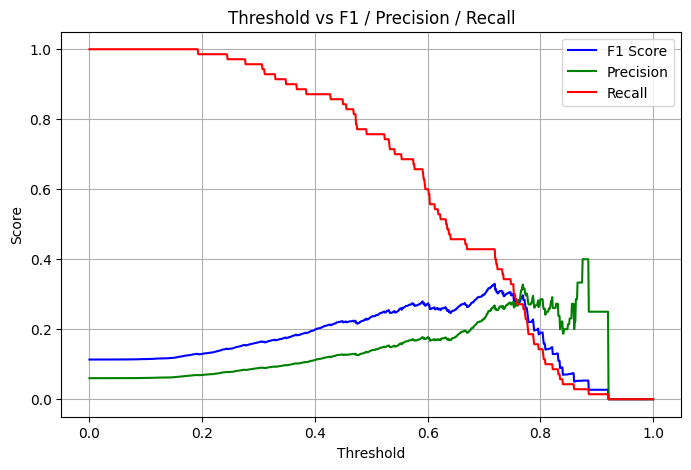

In [ ]:
#Rappel:
#Precision est overall precision. 
#Recall est la proportion des vrais targets trouvés (trouvé/(trouvé + non-trouvé))
#F1 score est une balance entre la précision et le recall. 

logisticRegression.plot_threshold_metrics(model, X_val_final_np, y_val_np, step=0.001)

Ah mais nn qu'est ce que je fais lol. Je dois continuer a optimizer le modèle au lieu d'optimiser le threshold et tout sa parce que sa ne va pas réellement améliorer le modèle. Je fais juste changer le t h r e s h o l d. Donc le seul truc qui est affecter est comment le modèle classe ses prédictions, il ne prédit pas mieux ou moins bien en modifiant les thresholds. Je vais retourner a un threshold basique de 0.5 et continuer d'amélioration les prédictions du modèles et quand j'ai fini, là je vais check a optimiser le threshold.

In [ ]:
model = tracker.get_by_name(INTER_TERMS_1_MODEL)

BASE_INTER_TERMS_1 = "BaseInterTerms1"
model.threshold = 0.5
model.print_stats(X_val_final_np, y_val_np)
tracker.add(model, BASE_INTER_TERMS_1)

Added interactions terms with auc gain > 0.003

Threshold:  0.5
Accuracy:  0.7047210300429184
[[768 327]
 [ 17  53]]
AUC:  0.8018395303326808
Model BaseInterTerms1 saved



Je vais expérimenter avec des poids de plus.

In [ ]:
model = Model.create_model_v2(X_train_final_np, y_train_np, X_val_final_np, y_val_np, learning_rate=learning_rate, extra_weight=ratio, improvement="Added extra weights to the cost function", to_print=True)
model.print_stats(X_val_final_np, y_val_np)


Iteration 0: Cost = 1.3035216307952924
Iteration 100: Cost = 1.1406988405380174
Iteration 200: Cost = 1.1225356090413017
Iteration 300: Cost = 1.112269191347845
Iteration 400: Cost = 1.1052935073054295
Iteration 500: Cost = 1.100058808420506
Iteration 600: Cost = 1.0958929422631138
Iteration 700: Cost = 1.092447616849225
Iteration 800: Cost = 1.0895185758833894
Iteration 900: Cost = 1.0869756513922388
Added extra weights to the cost function

Threshold:  0.5
Accuracy:  0.7047210300429184
[[768 327]
 [ 17  53]]
AUC:  0.8018395303326808


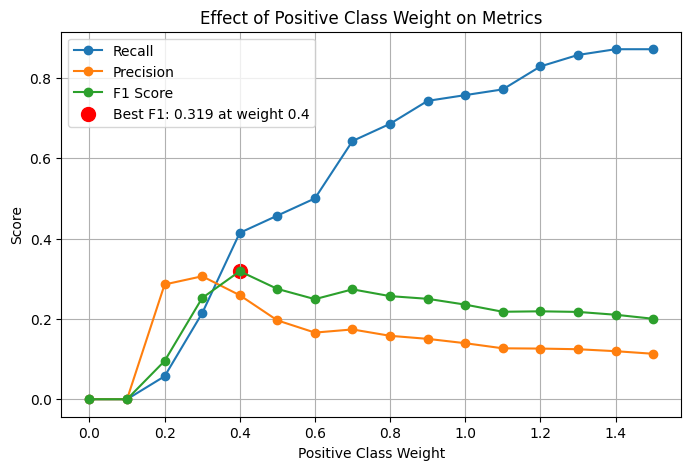

In [ ]:
weights_to_test = np.arange(0, 1.5 + 0.1, 0.1)
logisticRegression.plot_weights_effects(X_train_final_np, y_train_np, X_val_final_np, y_val_np, 0.5, ratio, weights_to_test, learning_rate=learning_rate)

In [ ]:
print(ratio)

15.748201438848922
